# Higher order ingredient pairings in world cuisines

>"What are the patterns at high order n-tuples (i.e. instead of pairs what if one were to compute triples and quadruples of ingredients)?"

>"Going beyond pairwise ingredient combinations, one may probe the patterns in recipes via higher order tuples."

## Imports

In [1]:
%pip install sklearn
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import itertools
import seaborn as sns
from collections import Counter
import networkx as nx 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, fpgrowth
import random
from itertools import combinations, islice
import math
import os
import pickle
from scipy.stats import norm
from collections import defaultdict
import multiprocess as mp
import sys
from tqdm import tqdm, trange

In [3]:
master_recipe_df_path = 'ProcessedDBs/master_recipe_df.pkl'
master_recipe_df = pd.read_pickle(master_recipe_df_path)
master_recipe_df

,Recipe ID,Title,Cuisine,Aliased Ingredient Name,Entity ID,Category,Dietary Style
0,1,5 spice vegetable fried rice,Indian Subcontinent,capsicum,362,Vegetable,Vegan
1,1,5 spice vegetable fried rice,Indian Subcontinent,pepper bell,362,Vegetable,Vegan
2,1,5 spice vegetable fried rice,Indian Subcontinent,soy sauce,291,Plant,Vegan
3,1,5 spice vegetable fried rice,Indian Subcontinent,sunflower,426,Flower,Vegan
4,2,aachar aaloo,Indian Subcontinent,buttermilk,61,Dairy,Lacto-Vegetarian
...,...,...,...,...,...,...,...
454138,45772,Enlightened Chicken Pot Pie,USA,salt,778,Additive,None
454139,45772,Enlightened Chicken Pot Pie,USA,squash yellow,493,Fruit,None
454140,45772,Enlightened Chicken Pot Pie,USA,thyme,269,Herb,None
454141,45772,Enlightened Chicken Pot Pie,USA,worcestershire sauce,2031,Dish,None


In [4]:
flavors_df_path = "ProcessedDBs/flavordb_ridf.pkl"
flavors_df = pd.read_pickle(flavors_df_path)
flavors_df

,index,Entity ID,Aliased Ingredient Name,Synonyms,Scientific Name,Category,Molecules,Group
0,0,0,egg,{egg},chicken,animal product,"{6274, 5311110, 644104, 9609, 18827, 527, 1960...",None
1,1,1,bakery products,{bakery products},poacceae,bakery,"{27457, 7976, 31252, 26808, 22201, 26331}",grain
2,2,2,bread,{bread},poacceae,bakery,"{1031, 1032, 644104, 527, 8723, 31260, 15394, ...",grain
3,3,3,rye bread,{rye bread},rye,bakery,"{644104, 7824, 643731, 8468, 1049, 5372954, 80...",grain
4,4,4,wheaten bread,"{soda scones, soda farls}",wheat,bakery,"{6915, 5365891, 12170, 8082, 31251, 7958, 1049...",grain
...,...,...,...,...,...,...,...,...
952,952,995,sauerkraut,{sauerkraut},sauerkraut,vegetable,"{6276, 8103, 1032, 9609, 31276, 1068, 8908, 52...",vegetable
953,953,994,tequila,{tequila},tequila,alcoholic beverage,{},beverage
954,954,2068,seal,{seal},seal,meat,"{7938, 13187, 18827, 5362572, 77837, 5281168, ...",protein
955,955,2086,herring,{herring},herring,seafood,"{5283329, 90246, 11527, 1032, 5283335, 1031, 5...",protein


In [5]:
master_recipe_df = master_recipe_df.merge(flavors_df[["Entity ID", "Group"]], on="Entity ID", how="left")

### Processed dicts

In [6]:
unique_cuisine_names = master_recipe_df['Cuisine'].unique().tolist()
unique_cuisine_names[:5]

['Indian Subcontinent', 'Africa', 'China', 'Thailand', 'South East Asia']

In [7]:
unique_cuisine_names_formatted = []
for name in unique_cuisine_names:
    unique_cuisine_names_formatted.append(name.replace(" ", "\n"))
unique_cuisine_names_formatted[:5]

['Indian\nSubcontinent', 'Africa', 'China', 'Thailand', 'South\nEast\nAsia']

In [8]:
unique_cuisine_names_file_formatted = {}
for name in unique_cuisine_names:
    unique_cuisine_names_file_formatted[name] = name.replace(" ", "_").lower()
unique_cuisine_names_file_formatted

{'Indian Subcontinent': 'indian_subcontinent',
 'Africa': 'africa',
 'China': 'china',
 'Thailand': 'thailand',
 'South East Asia': 'south_east_asia',
 'Middle East': 'middle_east',
 'Korea': 'korea',
 'Japan': 'japan',
 'Australia & NZ': 'australia_&_nz',
 'Mexico': 'mexico',
 'Caribbean': 'caribbean',
 'South America': 'south_america',
 'DACH Countries': 'dach_countries',
 'Greece': 'greece',
 'France': 'france',
 'Italy': 'italy',
 'British Isles': 'british_isles',
 'Scandinavia': 'scandinavia',
 'Eastern Europe': 'eastern_europe',
 'Spain': 'spain',
 'USA': 'usa',
 'Canada': 'canada'}

In [9]:
print("There are %s unique cuisines in the dataset." % len(unique_cuisine_names))

There are 22 unique cuisines in the dataset.


## 3. Data Analysis

### CuisineDB Stats

In [10]:
# Initialize an empty list to store the statistics for each cuisine
cuisine_stats_table = []

# Loop through each unique cuisine name in the list
for cuisine_name in unique_cuisine_names:
    # Calculate the number of recipes for the current cuisine
    recipe_count = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name]["Recipe ID"].unique().size

    # Calculate the average ingredient count per recipe for the current cuisine
    avg_ingredient_count = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name].groupby("Recipe ID")["Entity ID"].agg("count").mean()

    # Calculate the total number of unique ingredients for the current cuisine
    total_ingredient_count = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name]["Entity ID"].unique().size

    # Calculate the standard deviation of ingredient count per recipe for the current cuisine
    std_ingredient_count = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name].groupby("Recipe ID")['Recipe ID'].agg("count").std()

    # Append the statistics for the current cuisine to the cuisine_stats_table list
    cuisine_stats_table.append([cuisine_name, recipe_count, round(avg_ingredient_count, 1), total_ingredient_count, round(std_ingredient_count, 1)])

# Create a DataFrame from the cuisine_stats_table list
cuisine_stats_table_df = pd.DataFrame(cuisine_stats_table, columns=['Cuisine', 'Recipe Count', 'Avg Ingredient Count', 'Tot. Ingredient Count', 'STD Ingredient Count'])

# Display the DataFrame containing the cuisine statistics
cuisine_stats_table_df


,Cuisine,Recipe Count,Avg Ingredient Count,Tot. Ingredient Count,STD Ingredient Count
0,Indian Subcontinent,4057,8.5,383,5.0
1,Africa,650,12.0,307,5.5
2,China,941,11.5,299,4.9
3,Thailand,666,12.2,264,5.9
4,South East Asia,611,11.6,270,5.1
5,Middle East,993,10.6,313,4.9
6,Korea,301,10.7,199,5.5
7,Japan,578,9.0,280,4.7
8,Australia & NZ,494,8.8,293,3.4
9,Mexico,3138,9.0,372,4.1


In [11]:
cuisine_stats_table_df.describe()

,Recipe Count,Avg Ingredient Count,Tot. Ingredient Count,STD Ingredient Count
count,22.000000,22.000000,22.000000,22.000000
mean,2070.090909,10.186364,320.500000,4.822727
std,3550.636441,1.093834,86.975503,0.683083
min,301.000000,8.500000,199.000000,3.400000
25%,568.250000,9.300000,265.500000,4.350000
50%,874.500000,10.050000,303.000000,4.900000
75%,1109.750000,10.925000,357.250000,5.375000
max,16106.000000,12.200000,595.000000,5.900000


#### Ingredients

In [12]:
# Extracting only the necessary columns "Recipe ID" and "Cuisine" from the master_recipe_df DataFrame
tmp_master_recipe_df = master_recipe_df[["Recipe ID", "Cuisine"]]

# Using a groupby operation to count the number of unique "Entity ID" occurrences for each "Recipe ID"
ingredient_counts = master_recipe_df[["Recipe ID", "Entity ID", "Cuisine"]].groupby("Recipe ID")["Entity ID"].count()

# Joining the calculated ingredient_counts Series with the tmp_master_recipe_df DataFrame on "Recipe ID"
# The "rsuffix" parameter is used to avoid column name conflicts in the join operation
tmp_master_recipe_df = tmp_master_recipe_df.join(ingredient_counts, on="Recipe ID", rsuffix="_Ingredient_Count")

# Renaming the column "Entity ID" to "Ingredient Count"
tmp_master_recipe_df.rename(columns={"Entity ID": "Ingredient Count"}, inplace=True)

# Dropping any duplicate rows from the DataFrame to ensure uniqueness based on "Recipe ID"
tmp_master_recipe_df.drop_duplicates(inplace=True)

,Recipe ID,Cuisine,Ingredient Count
0,1,Indian Subcontinent,4
4,2,Indian Subcontinent,9
13,3,Indian Subcontinent,8
21,4,Indian Subcontinent,14
35,5,Indian Subcontinent,3
...,...,...,...
454096,45768,USA,4
454100,45769,USA,12
454112,45770,USA,8
454120,45771,USA,7


/Users/jamesmarcogliese/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

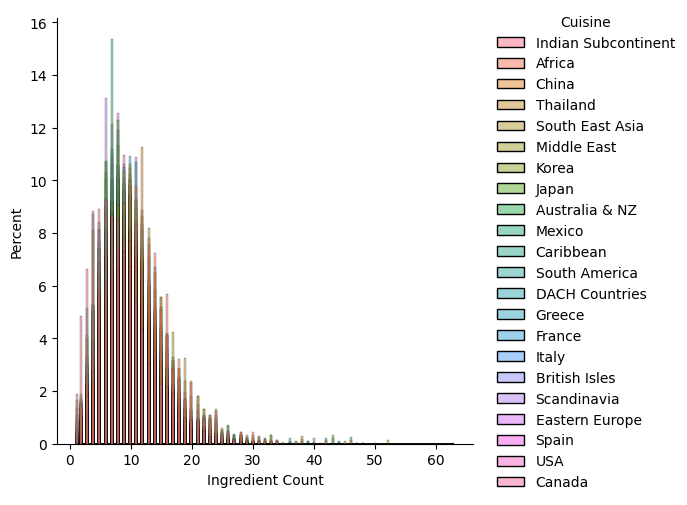

In [13]:
# common_norm=True will show the percent as a part of the entire population, whereas False will show the percent relative to the group.
plt.clf()
p = sns.displot(tmp_master_recipe_df, x='Ingredient Count', hue="Cuisine", stat='percent', common_norm=False)
plt.show()

<Axes: xlabel='Ingredient Count', ylabel='Cuisine'>

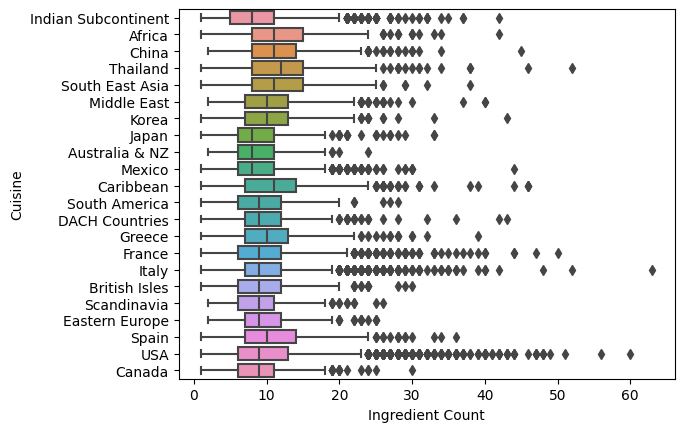

In [15]:
sns.boxplot(data=tmp_master_recipe_df, x='Ingredient Count', y="Cuisine", orient="h")

#### Ingredient Categories

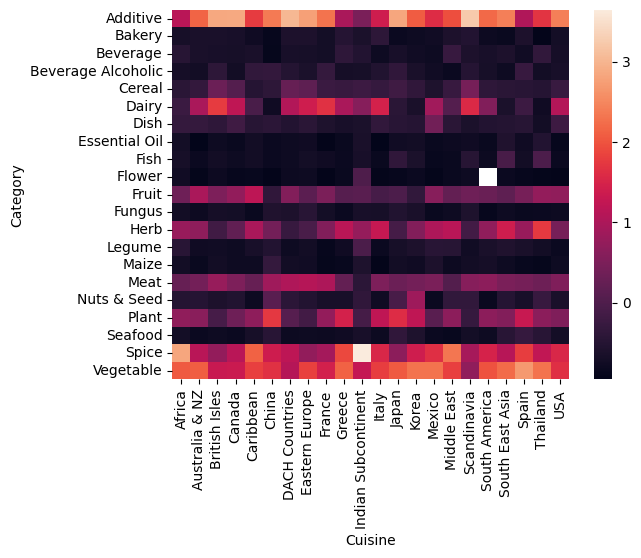

In [18]:
data = master_recipe_df.groupby(['Cuisine','Category']).size().unstack(level=0)
data=(data-data.mean())/data.std()
ax = sns.heatmap(data=data)
plt.show()

#### Breakdown of cuisines by dietary style

In [19]:
# Initialize an empty dictionary to store dietary style statistics
dietary_stats_values = {}

# Loop through each unique dietary style in the 'master_recipe_df' DataFrame
for style in master_recipe_df["Dietary Style"].unique().tolist():
    # Initialize an empty list to store the count of recipes for each cuisine under the current dietary style
    style_count = [] 

    # Loop through each unique cuisine name
    for cuisine_name in unique_cuisine_names:
        # Filter 'master_recipe_df' based on the current cuisine and dietary style, then count the number of recipes
        count = master_recipe_df[
            (master_recipe_df['Cuisine'] == cuisine_name) & (master_recipe_df['Dietary Style'] == style)
        ].count()["Recipe ID"]

        # Append the count to the 'style_count' list
        style_count.append(count)

    # Store the 'style_count' list for the current dietary style in the 'dietary_stats_values' dictionary
    dietary_stats_values[style] = style_count

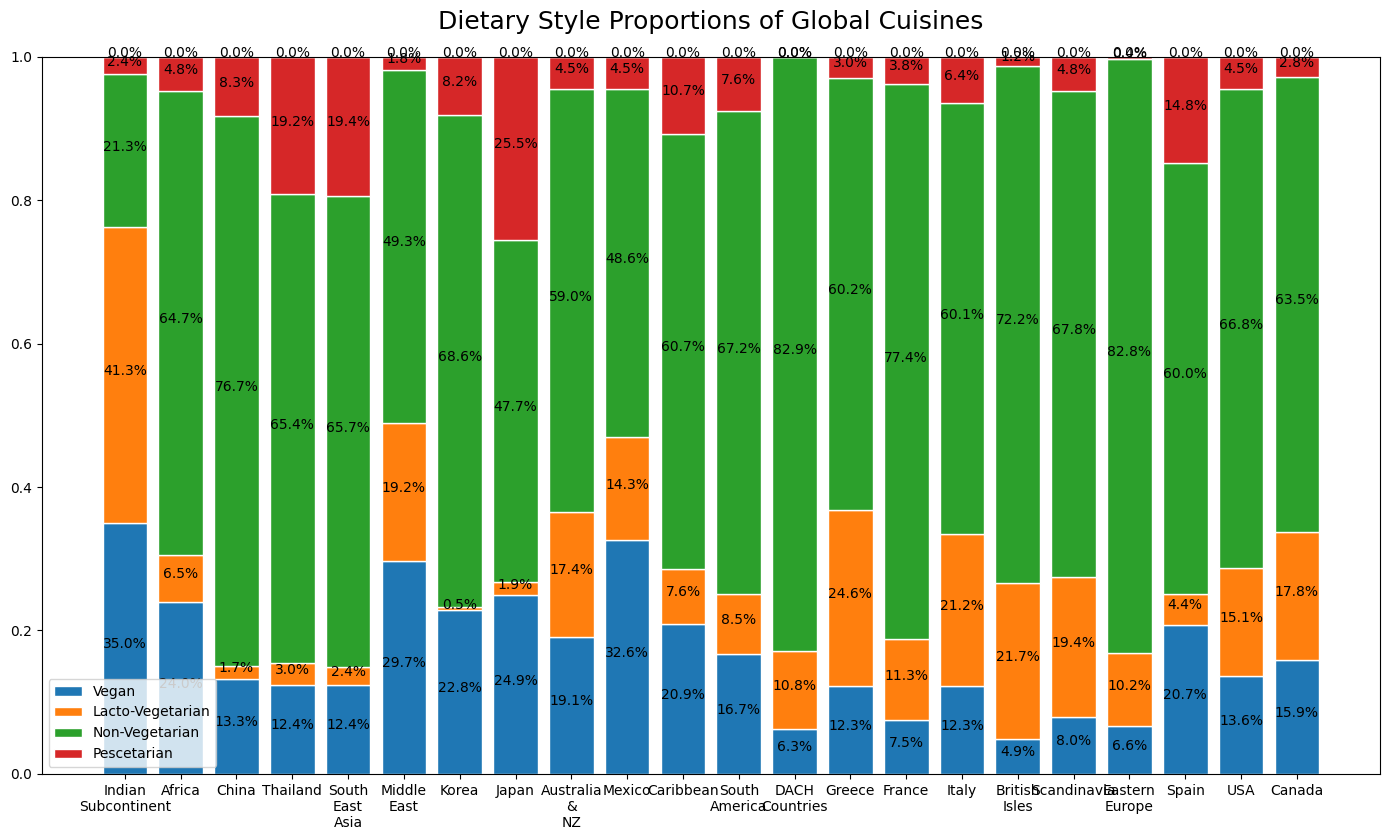

In [20]:
# Data to plot
values = dietary_stats_values  # Assuming this dictionary contains values for different dietary stats
criteria = unique_cuisine_names_formatted  # Assuming this list contains formatted cuisine names

# Calculate percentage values
totals = np.sum(list(values.values()), axis=0)
values_pct = {key: np.array(value) / totals for key, value in values.items()}

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 8.5))  # Adjusted size for legal-sized page

bottom = np.zeros(len(criteria))
for key, pct_values in values_pct.items():
    ax.bar(criteria, pct_values, bottom=bottom, label=key, edgecolor='w')  # Plotting the bars for each dietary stat
    
    # Adding percentage labels on top of each bar
    for i, v in enumerate(pct_values):
        ax.text(i, bottom[i] + v / 2, '{:.1f}%'.format(v * 100), horizontalalignment='center')
    
    bottom += pct_values

# Set plot properties
ax.set_title('Dietary Style Proportions of Global Cuisines', fontsize=18, pad=20)  # Adjusted fontsize
ax.set_xticks(range(len(criteria)))
ax.set_xticklabels(criteria, fontsize=10)  # Adjusted fontsize
ax.set_ylim(0, 1)  # Setting the y-axis limits to 0 and 1 for better visualization of percentages
plt.legend(fontsize=10)  # Adjusted fontsize

plt.tight_layout()  # Added to optimize spacing and fit on the page

# Save the plot as an image (Optional: Uncomment this line to save the plot as 'dietary_style_proportions.png')
# plt.savefig('dietary_style_proportions.png', dpi=300)

plt.show()  # Display the plot


### FlavourDB Stats

/var/folders/tk/3mpzsdc17flggsprn40wq3380000gn/T/ipykernel_69758/2828050497.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


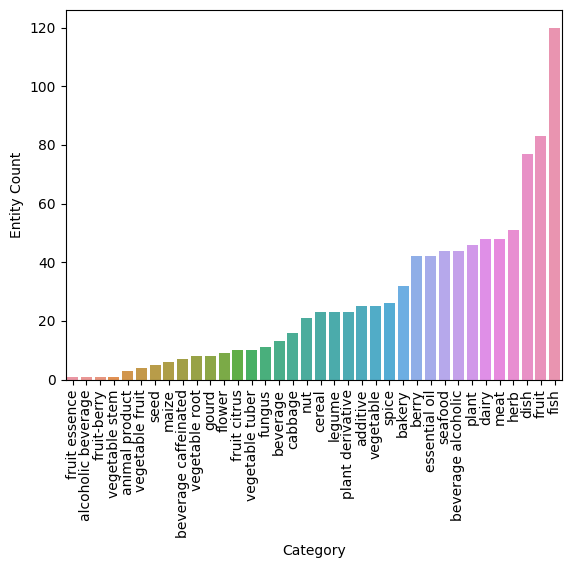

In [21]:
plot = sns.barplot(
    data= flavors_df.groupby(['Category']).size().sort_values(ascending=True).to_frame().reset_index().rename(columns={0:'Count'}),
    x= 'Category',
    y= 'Count',
    ci=None)

plt.ylabel('Entity Count')
plt.xlabel('Category')
plt.xticks(rotation=90) 
plt.show()

/var/folders/tk/3mpzsdc17flggsprn40wq3380000gn/T/ipykernel_69758/2129202210.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


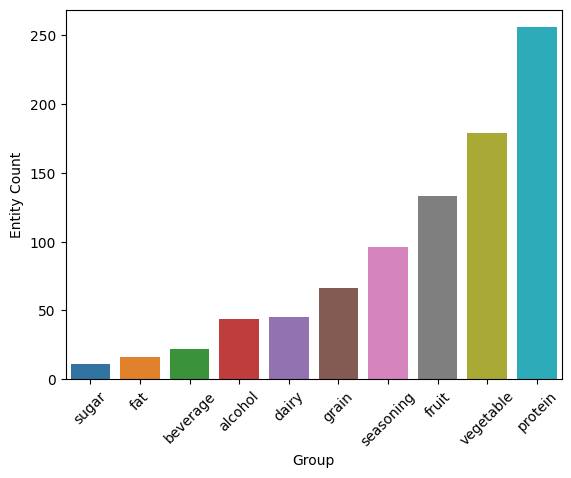

In [22]:
plot = sns.barplot(
    data= flavors_df.groupby(['Group']).size().sort_values(ascending=True).to_frame().reset_index().rename(columns={0:'Count'}),
    x= 'Group',
    y= 'Count',
    ci=None)

plt.ylabel('Entity Count')
plt.xlabel('Group')
plt.xticks(rotation=45) 
plt.show()

/var/folders/tk/3mpzsdc17flggsprn40wq3380000gn/T/ipykernel_69758/1903290416.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Avg. Molecules', data=avg_molecules, ci=None, order=avg_molecules.sort_values('Avg. Molecules').Category.unique())


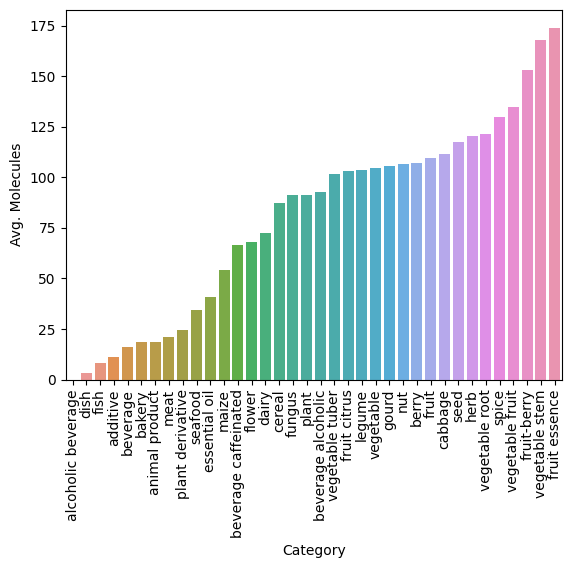

In [23]:
avg_molecules = flavors_df.groupby(['Entity ID', 'Category'])['Molecules'].apply(lambda x: len(set.union(*x))).reset_index()
avg_molecules.rename(columns={'Molecules': 'Avg. Molecules'}, inplace=True)
avg_molecules = avg_molecules.groupby(['Category'])['Avg. Molecules'].mean().sort_values(ascending=True).to_frame().reset_index()

sns.barplot(x='Category', y='Avg. Molecules', data=avg_molecules, ci=None, order=avg_molecules.sort_values('Avg. Molecules').Category.unique())
plt.xticks(rotation=90) 
plt.show()

/var/folders/tk/3mpzsdc17flggsprn40wq3380000gn/T/ipykernel_69758/3438427503.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Group', y='Avg. Molecules', data=avg_molecules, ci=None, order=avg_molecules.sort_values('Avg. Molecules').Group.unique())


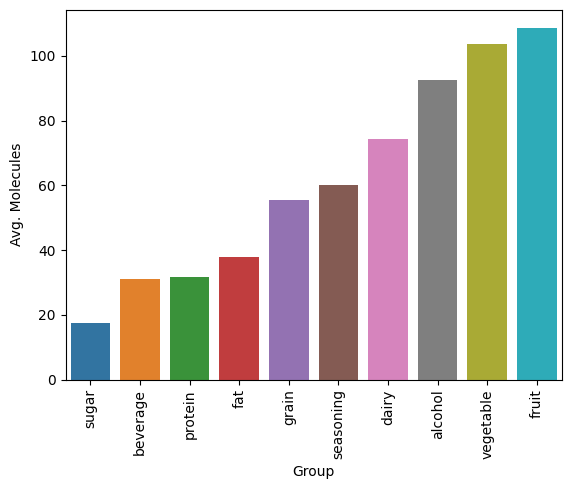

In [24]:
avg_molecules = flavors_df.groupby(['Entity ID', 'Group'])['Molecules'].apply(lambda x: len(set.union(*x))).reset_index()
avg_molecules.rename(columns={'Molecules': 'Avg. Molecules'}, inplace=True)
avg_molecules = avg_molecules.groupby(['Group'])['Avg. Molecules'].mean().sort_values(ascending=True).to_frame().reset_index()

sns.barplot(x='Group', y='Avg. Molecules', data=avg_molecules, ci=None, order=avg_molecules.sort_values('Avg. Molecules').Group.unique())
plt.xlabel('Group')
plt.xticks(rotation=90) 
plt.show()

### Rand Cuisines

In [25]:
cuisine_ingredient_frequencies = {}
cuisine_category_frequencies = {}
cuisine_group_frequencies = {}

for cuisine_name in unique_cuisine_names:
    
    # Calculate the frequencies of ingredients in the dataset
    ingredient_counts = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name]['Entity ID'].value_counts()
    cuisine_ingredient_frequencies[cuisine_name] = ingredient_counts

    # Calculate the frequencies of categories in the dataset
    category_counts = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name]['Category'].value_counts()
    cuisine_category_frequencies[cuisine_name] = category_counts
    
    # Calculate the frequencies of groups in the dataset
    group_counts = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name]['Group'].value_counts()
    cuisine_group_frequencies[cuisine_name] = group_counts
    


In [26]:
def generate_recipe(weighted_ingredients, num_ingredients, max_population_size):
    """
    Generate a recipe that is frequency-conserving and ingredient category preserving.

    Parameters:
    - weighted_ingredients: A list of frequencies corresponding to each ingredient in the cuisine.
    - num_ingredients: The number of ingredients to include in the recipe.

    Returns:
    - The generated recipe as a list of ingredients.
    """

    # Limit num_ingredients to a minimum of zero
    num_ingredients = max(num_ingredients, 0)
    # Adjust num_ingredients if it exceeds the population size
    num_ingredients = min(num_ingredients, max_population_size)
    
    # Randomly select ingredients from the weighted list to form the recipe
    recipe = random.sample(weighted_ingredients, num_ingredients)

    return recipe

def generate_cuisine(mean_num_ingredients,
                    sd_num_ingredients,
                    num_recipies,
                    cuisine_name,
                    weighted_ingredients,
                    max_num_ingredients):

    rand_list = []
    
    for recipe_id in range(num_recipies):

        # Generate a random number of ingredients using a Gaussian distribution
        num_ingredients = int(np.random.normal(mean_num_ingredients, sd_num_ingredients))

        # Call the generate_recipe function with the generated num_ingredients
        recipe = generate_recipe(weighted_ingredients, num_ingredients, max_num_ingredients)
        
        # Pop into tmp_df to preform same step as before, then substract rand cuisine score from actual
        for entity_id in recipe:
            rand_list.append([cuisine_name, recipe_id, entity_id])
            
    return rand_list


In [27]:
NUM_RANDOM_RECIPIES = 100000
use_cuisine_recipe_count = True
rand_uniform_list = []
rand_ingredient_freq_list = []
rand_category_freq_list = []
rand_group_freq_list = []

if os.path.exists('exported_vectors/rand_uniform_list.pkl'):
    with open('exported_vectors/rand_uniform_list.pkl', 'rb') as file:
        rand_uniform_list = pickle.load(file)
    with open('exported_vectors/rand_ingredient_freq_list.pkl', 'rb') as file:
        rand_ingredient_freq_list = pickle.load(file)
    with open('exported_vectors/rand_category_freq_list.pkl', 'rb') as file:
        rand_category_freq_list = pickle.load(file)
    with open('exported_vectors/rand_group_freq_list.pkl', 'rb') as file:
        rand_group_freq_list = pickle.load(file)

else:
    for cuisine_name in unique_cuisine_names:
        #print(cuisine_name)
        
        # Retrieve the mean and standard deviation for the number of ingredients
        mean_num_ingredients = cuisine_stats_table_df[cuisine_stats_table_df["Cuisine"] == cuisine_name].iloc[0]['Avg Ingredient Count']
        sd_num_ingredients = cuisine_stats_table_df[cuisine_stats_table_df["Cuisine"] == cuisine_name].iloc[0]['STD Ingredient Count']
        max_num_ingredients = cuisine_stats_table_df[cuisine_stats_table_df["Cuisine"] == cuisine_name].iloc[0]['Tot. Ingredient Count']
        num_recipies = cuisine_stats_table_df[cuisine_stats_table_df["Cuisine"] == cuisine_name].iloc[0]['Recipe Count']
        
        if not use_cuisine_recipe_count:
            num_recipies = NUM_RANDOM_RECIPIES
        
        # Create control sets for each cuisine
        ## Random control set
        weighted_ingredients = cuisine_ingredient_frequencies[cuisine_name].index.tolist() # No weights for random control set
        rand_list_tmp = generate_cuisine(mean_num_ingredients, sd_num_ingredients, num_recipies, cuisine_name, weighted_ingredients, max_num_ingredients)
        rand_uniform_list = rand_uniform_list + rand_list_tmp
        
        ## Weighted ingredient control set
        weighted_ingredients = []
        cuisine_counts = cuisine_ingredient_frequencies[cuisine_name]
        for group, frequency in zip(cuisine_counts.index.tolist(), cuisine_counts.values.tolist()):
            weighted_ingredients.extend([group] * frequency)
        rand_list_tmp = generate_cuisine(mean_num_ingredients, sd_num_ingredients, num_recipies, cuisine_name, weighted_ingredients, max_num_ingredients)
        rand_ingredient_freq_list = rand_ingredient_freq_list + rand_list_tmp
            
        ## Weighted category control set
        weighted_ingredients = []
        cuisine_counts = cuisine_category_frequencies[cuisine_name]
        for group, frequency in zip(cuisine_counts.index.tolist(), cuisine_counts.values.tolist()):
            tmp_df = master_recipe_df[(master_recipe_df['Cuisine'] == cuisine_name) & (master_recipe_df['Category'] == group)]
            if not tmp_df.empty and frequency > 0:
                weighted_ingredients.extend(np.random.choice(tmp_df['Entity ID'].unique(), size=frequency).tolist())
        rand_list_tmp = generate_cuisine(mean_num_ingredients, sd_num_ingredients, num_recipies, cuisine_name, weighted_ingredients, max_num_ingredients)
        rand_category_freq_list = rand_category_freq_list + rand_list_tmp
        
        ## Weighted group control set
        weighted_ingredients = []
        cuisine_counts = cuisine_group_frequencies[cuisine_name]
        for group, frequency in zip(cuisine_counts.index.tolist(), cuisine_counts.values.tolist()):
            tmp_df = master_recipe_df[(master_recipe_df['Cuisine'] == cuisine_name) & (master_recipe_df['Group'] == group)]
            if not tmp_df.empty and frequency > 0:
                weighted_ingredients.extend(np.random.choice(tmp_df['Entity ID'].unique(), size=frequency).tolist())
        rand_list_tmp = generate_cuisine(mean_num_ingredients, sd_num_ingredients, num_recipies, cuisine_name, weighted_ingredients, max_num_ingredients)
        rand_group_freq_list = rand_group_freq_list + rand_list_tmp
        
    # Pickle for later use
    with open('exported_vectors/rand_uniform_list.pkl', 'wb') as file:
        pickle.dump(rand_uniform_list, file)
    with open('exported_vectors/rand_ingredient_freq_list.pkl', 'wb') as file:
        pickle.dump(rand_ingredient_freq_list, file)
    with open('exported_vectors/rand_category_freq_list.pkl', 'wb') as file:
        pickle.dump(rand_category_freq_list, file)
    with open('exported_vectors/rand_group_freq_list.pkl', 'wb') as file:
        pickle.dump(rand_group_freq_list, file)


rand_uniform_df = pd.DataFrame(rand_uniform_list, columns=['Cuisine', 'Recipe ID', 'Entity ID'])
rand_ingredient_freq_df = pd.DataFrame(rand_ingredient_freq_list, columns=['Cuisine', 'Recipe ID', 'Entity ID'])
rand_category_freq_df = pd.DataFrame(rand_category_freq_list, columns=['Cuisine', 'Recipe ID', 'Entity ID'])
rand_group_freq_df = pd.DataFrame(rand_group_freq_list, columns=['Cuisine', 'Recipe ID', 'Entity ID'])

del rand_uniform_list
del rand_ingredient_freq_list
del rand_category_freq_list
del rand_group_freq_list

### Flavour Pairing

In [28]:
import numpy as np

def find_ingredient(ingredient_name, fdf):
    """
    Find the ingredient(s) in the DataFrame that match the given ingredient_name.
    Returns a subset of the DataFrame containing the matching ingredient(s).
    """
    return fdf[
        (fdf['Aliased Ingredient Name'] == ingredient_name) | (ingredient_name in fdf['Synonyms'])
    ]

def find_molecules(ingredient_name, fdf):
    """
    Find the molecules associated with the given ingredient_name.
    Returns a list of molecules for the matching ingredient.
    Raises a ValueError if there are more than one entry for the ingredient.
    """
    ingredients = find_ingredient(ingredient_name, fdf)
    molecules = list(ingredients['Molecules'])
    if len(molecules) > 1:
        raise ValueError(f"Ingredient '{ingredient_name}' has more than one entry")
    return molecules[0]

def mean_shared_compounds(ingredients, fdf, **kwargs):
    """
    Calculate the mean shared compounds (MSC) for a given recipe (set of ingredients).
    MSC is the sum of the number of shared compounds per pair of ingredients,
    divided by the number of combinations of two ingredients.
    """
    use_index = kwargs.get('use_index', False)

    if use_index:
        # Retrieve the molecules for the ingredients using their indices
        molecules = []
        for i in ingredients:
            try:
                # In case an entity can't be found, skip it
                molecule = fdf.at[i, 'Molecules']
                molecules.append(molecule)
            except KeyError:
                pass  
    else:
        # Retrieve the molecules for the ingredients by name
        molecules = [find_molecules(ingredient, fdf) for ingredient in ingredients]

    found_ingredients = len(molecules)
    shared_compounds = 0

    # Calculate the shared compounds for each pair of ingredients
    for i in range(found_ingredients):
        for j in range(i + 1, found_ingredients):
            shared_compounds += abs(len(molecules[i].intersection(molecules[j])))

    # Calculate the mean shared compounds
    msc = 0.0
    try:
        msc = (2.0 * shared_compounds) / (found_ingredients * (found_ingredients - 1))
    except ZeroDivisionError:
        return None
    
    return msc

def block_mean_shared_compounds(recipe0, recipe1, fdf, **kwargs):
    """
    Calculate the mean shared compounds (MSC) when comparing each ingredient in recipe0
    to each ingredient in recipe1.
    """
    len0 = len(recipe0)
    len1 = len(recipe1)

    # Initialize the result array
    msc_array = np.ndarray((len0, len1))

    # Calculate the MSC for each pair of ingredients
    for i in range(len0):
        for j in range(len1):
            msc_array[i][j] = mean_shared_compounds(
                [recipe0[i], recipe1[j]],
                fdf,
                **kwargs
            )

    return msc_array

def intragroup_mean_shared_compounds(ingredients, fdf, **kwargs):
    """
    Calculate the mean shared compounds (MSC) within a group of ingredients.
    Returns a 2D list containing the MSC values for each pair of ingredients in the group.
    """
    num_ingredients = len(ingredients)

    # Calculate the block mean shared compounds within the group
    block_msc_array = block_mean_shared_compounds(
        ingredients,
        ingredients,
        fdf,
        **kwargs
    )

    msc_list = []
    for i in range(num_ingredients):
        msc_list.append([])
        for j in range(1 + i, num_ingredients):
            # Retrieve the relevant MSC values from the block array
            msc_list[-1].append(block_msc_array[i][j])

    return msc_list

def intergroup_msc_score(recipes, fdf, return_sd=False, **kwargs):
    """
    Calculate the intergroup mean shared compounds (MSC) score for a list of recipes.
    Returns the average MSC score across all recipes.
    """
    recipe_msc_scores = []

    for recipe in recipes:
        recipe_msc = mean_shared_compounds(recipe, fdf, **kwargs)
        if recipe_msc is not None:
            recipe_msc_scores.append(recipe_msc)

    avg_msc_score = sum(recipe_msc_scores) / len(recipe_msc_scores)

    if return_sd:
        return avg_msc_score, np.std(recipe_msc_scores)
    else:
        return avg_msc_score

def flatten(lst):
    """
    Flatten a nested list into a single-level list.
    """
    flattened_list = [x for sublist in lst for x in sublist]
    return flattened_list


#### Intragroup

In [29]:
msc_data = flatten(intragroup_mean_shared_compounds(flavors_df.index, flavors_df, use_index=True))

Average: 18.32473122510635
Median: 2.0


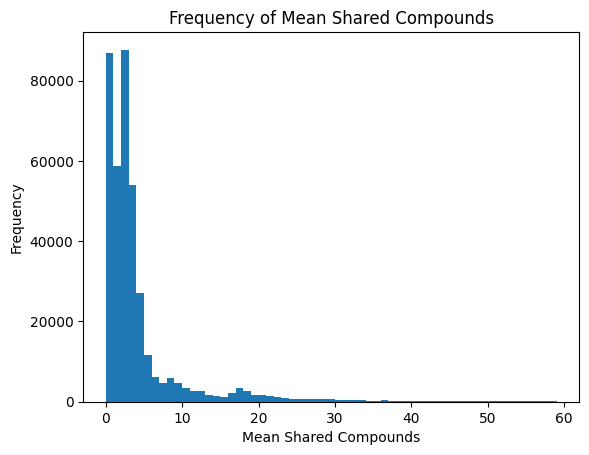

In [30]:
average = np.average(msc_data)
median = np.median(msc_data)

print(f"Average: {average}")
print(f"Median: {median}")

plt.hist(msc_data, bins=list(range(60)))
plt.title('Frequency of Mean Shared Compounds')
plt.xlabel('Mean Shared Compounds')
plt.ylabel('Frequency')
plt.show()


In [31]:
def make_violin_plot(x, y, **kwargs):
    """
    Create a violin plot with the given x and y data.
    Additional optional parameters: x_label, y_label, title, widths, figsize.
    """
    x_label = kwargs.get('x_label', '')
    y_label = kwargs.get('y_label', '')
    title = kwargs.get('title', '')
    widths = kwargs.get('widths', 4)
    figsize = kwargs.get('figsize', (10, 7.5))
    
    # Create a sufficiently wide violin plot, with a median
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.violinplot(y, x, widths=widths, showmedians=True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    # Display the plot
    #plt.show()


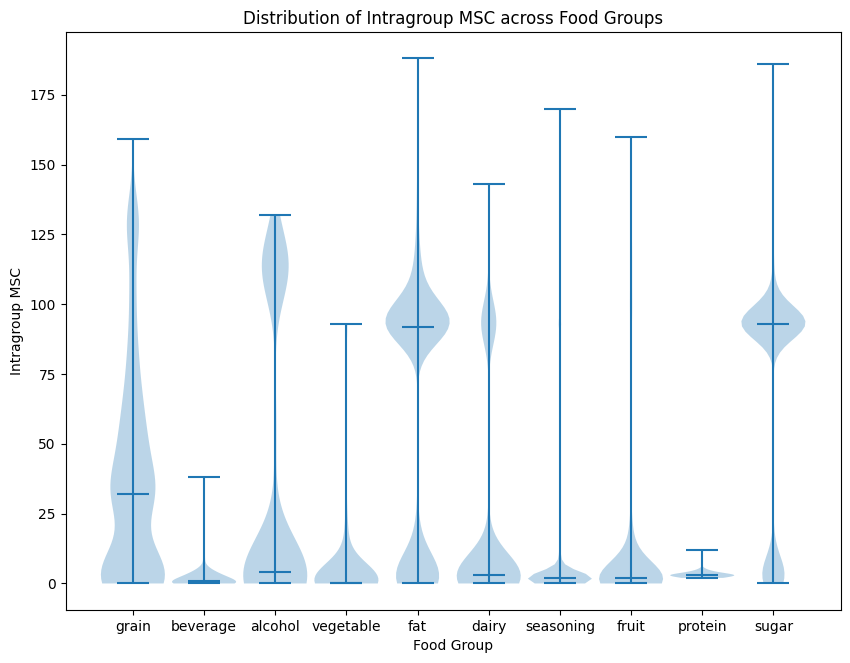

In [32]:
# Filter rows where the 'Group' column is not None
tmp = flavors_df[[g is not None for g in flavors_df['Group']]]

# Group the filtered DataFrame by the 'Group' column
food_grouped = tmp.groupby(by='Group')

# Get unique values of 'Group' for x-axis labels
x = tmp['Group'].unique()

# Generate x-axis tick positions
xticks = list(range(len(x)))

# Calculate the intragroup mean shared compounds for each group
# The result 'y' will be a list of intragroup mean shared compounds for each group.
y = [
    flatten(intragroup_mean_shared_compounds(list(group.index), tmp, use_index=True))
    for _, group in food_grouped
]

make_violin_plot(
    xticks,
    y,
    widths=0.9,
    x_label='Food Group',
    y_label='Intragroup MSC',
    title='Distribution of Intragroup MSC across Food Groups'
)

# Set the x-axis tick labels using the unique 'Group' values
plt.xticks(xticks, x)

# Display the plot
plt.show()


#### Extragroup

In [33]:
def scatter_plot(cuisines, scatter_sets, labels, x_label, y_label, title, **kwargs):
    """
    Visualize the relative MSC scores across cuisines using a bar chart.
    """
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

    for scatter_set in scatter_sets:
        ax.scatter(cuisines, scatter_set, label=labels.pop(0))

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    plt.axhline(y = 0, color = 'r', linestyle = '-')

    plt.legend(loc='upper left')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Optimize spacing
    plt.show()


In [34]:
tmp_df = pd.merge(master_recipe_df, flavors_df[["Molecules",'Entity ID']], on="Entity ID", how="left")
tmp_df['Entity ID'] = tmp_df['Entity ID'].astype('Int64')
#tmp_df

In [35]:
# Initialize an empty list to store the calculated msc_scores
msc_scores = []

# Iterate over each unique cuisine_name in the list unique_cuisine_names
for cuisine_name in unique_cuisine_names:
    # Filter the DataFrame tmp_df to get rows where the 'Cuisine' column matches the current cuisine_name
    filtered_df = tmp_df[tmp_df['Cuisine'] == cuisine_name]
    
    # Group the 'Entity ID' values based on the 'Recipe ID' and convert them to nested arrays
    nested_array = filtered_df.groupby('Recipe ID')['Entity ID'].apply(list).tolist()
    
    # Call the function intergroup_msc_score to calculate the msc_score
    # The function takes nested_array, flavors_df, and use_index=True as arguments
    msc_score = intergroup_msc_score(nested_array, flavors_df, use_index=True)
    
    # Append the calculated msc_score to the msc_scores list
    msc_scores.append(msc_score)


In [36]:
# Initialize an empty list to store MSC scores calculated using random data
msc_scores_rand = []

# Loop through each cuisine name in the unique_cuisine_names list
for cuisine_name in unique_cuisine_names:
    # Filter the rand_uniform_df to get rows with the current cuisine_name and group by 'Recipe ID', 
    # then convert the 'Entity ID' column to nested arrays for each group and store them in a list
    nested_array = rand_uniform_df[rand_uniform_df['Cuisine'] == cuisine_name].groupby('Recipe ID')['Entity ID'].apply(list).tolist()

    # Calculate the intergroup MSC score using the nested_array and flavors_df data,
    # with the use_index flag set to True
    msc_score = intergroup_msc_score(nested_array, flavors_df, use_index=True)

    # Append the calculated MSC score to the msc_scores_rand list
    msc_scores_rand.append(msc_score)

# Calculate the differences between the msc_scores and msc_scores_rand lists using NumPy's subtract function
msc_scores_delta = list(np.subtract(msc_scores, msc_scores_rand))


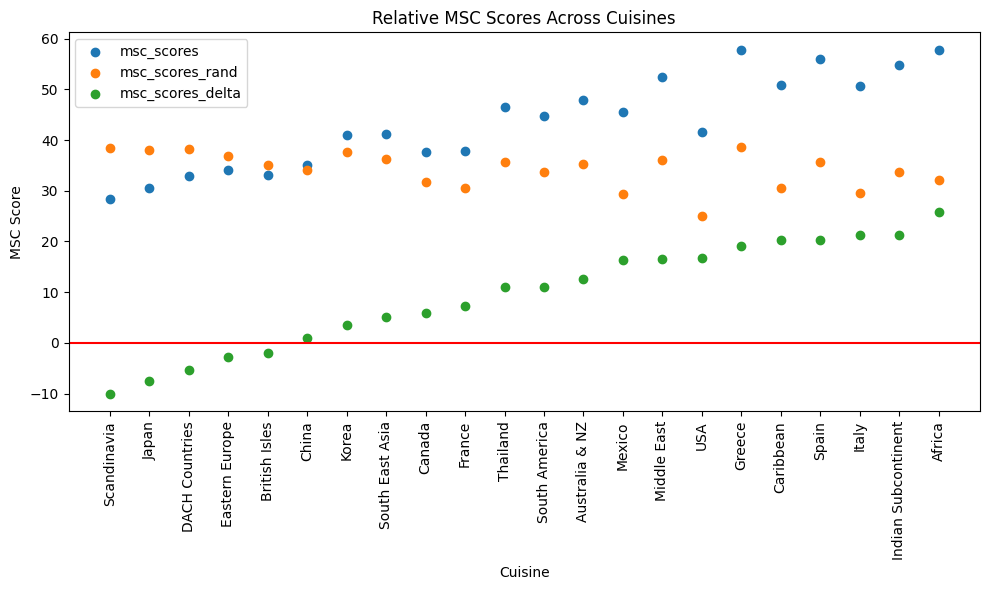

In [37]:
# Sort scores and cuisines by ascending order of scores
xyza = list(zip(msc_scores, msc_scores_rand, msc_scores_delta, unique_cuisine_names))
xyza = sorted(xyza, key=lambda x: x[2], reverse=False)

x_sorted = [x for x, y, z, a in xyza]
y_sorted = [y for x, y, z, a in xyza]
z_sorted = [z for x, y, z, a in xyza]
a_sorted = [a for x, y, z, a in xyza]

scatter_plot(a_sorted, 
             [x_sorted, y_sorted, z_sorted], 
             ["msc_scores", "msc_scores_rand", "msc_scores_delta"],
             "Cuisine",
             "MSC Score",
             "Relative MSC Scores Across Cuisines")

In [38]:
msc_stats_table = []

for i in range(len(a_sorted)):
    msc_stats_table.append([a_sorted[i], round(x_sorted[i],3), round(y_sorted[i],3), round(z_sorted[i],3)])

msc_stats_table_df = pd.DataFrame(msc_stats_table, columns=['Cuisine', "msc_scores", "msc_scores_rand", "msc_scores_delta"])
msc_stats_table_df

,Cuisine,msc_scores,msc_scores_rand,msc_scores_delta
0,Scandinavia,28.309,38.426,-10.117
1,Japan,30.565,38.097,-7.532
2,DACH Countries,32.845,38.222,-5.378
3,Eastern Europe,34.053,36.850,-2.796
4,British Isles,33.052,35.099,-2.047
5,China,35.028,34.084,0.944
6,Korea,41.083,37.584,3.499
7,South East Asia,41.259,36.234,5.025
8,Canada,37.616,31.687,5.929
9,France,37.907,30.592,7.315


In [39]:
def calculate_z_score(rand_num_recipes, cuisine_msc_score, rand_msc_score, rand_msc_sd):
    """
    Calculates the Z-score for a cuisine's Mean Squared Co-occurrence (MSC) score.
    
    Parameters:
        rand_num_recipes (float): The number of random recipes used for comparison.
        cuisine_msc_score (float): MSC score of the target cuisine.
        rand_msc_score (float): Average MSC score from random recipes.
        rand_msc_sd (float): Standard deviation of MSC scores from random recipes.
        
    Returns:
        float: The calculated Z-score for the cuisine's MSC score.
    """
    return math.sqrt(rand_num_recipes) * (cuisine_msc_score - rand_msc_score) / rand_msc_sd

def calculate_cuisine_z_scores(rand_df, flavors_df, msc_stats_table_df, unique_cuisine_names):
    """
    Calculates Z-scores for each cuisine's Mean Squared Co-occurrence (MSC) score.
    
    Parameters:
        rand_df (DataFrame): Dataframe containing random recipes' co-occurrence data.
        flavors_df (DataFrame): Dataframe containing flavors data.
        msc_stats_table_df (DataFrame): Dataframe containing MSC scores for each cuisine.
        unique_cuisine_names (list): List of unique cuisine names to calculate Z-scores for.
        
    Returns:
        list: A list of Z-scores corresponding to each cuisine's MSC score.
    """
    z_scores = []
    for cuisine_name in unique_cuisine_names:
        # Extract co-occurrence data for the current cuisine from the random dataframe.
        nested_array = rand_df[rand_df['Cuisine'] == cuisine_name].groupby('Recipe ID')['Entity ID'].apply(list).tolist()
        
        # Calculate the MSC score and standard deviation from random data for the current cuisine.
        rand_msc_score, rand_msc_sd = intergroup_msc_score(nested_array, flavors_df, use_index=True, return_sd=True)
        
        # Calculate the Z-score for the current cuisine's MSC score.
        z_score = calculate_z_score(
            NUM_RANDOM_RECIPES,
            msc_stats_table_df[msc_stats_table_df["Cuisine"] == cuisine_name]["msc_scores"].values[0],
            rand_msc_score,
            rand_msc_sd
        )
        
        # Append the calculated Z-score to the list.
        z_scores.append(z_score)
        
    return z_scores


In [40]:
z_scores_rand_uniform_freq = []
z_scores_rand_ingredient_freq = []
z_scores_rand_category_freq = []
z_scores_rand_group_freq = []

if os.path.exists('exported_vectors/z_scores_rand_uniform_freq.pkl'):
    with open('exported_vectors/z_scores_rand_uniform_freq.pkl', 'rb') as file:
        z_scores_rand_uniform_freq = pickle.load(file)
    with open('exported_vectors/z_scores_rand_ingredient_freq.pkl', 'rb') as file:
        z_scores_rand_ingredient_freq = pickle.load(file)
    with open('exported_vectors/z_scores_rand_category_freq.pkl', 'rb') as file:
        z_scores_rand_category_freq = pickle.load(file)
    with open('exported_vectors/z_scores_rand_group_freq.pkl', 'rb') as file:
        z_scores_rand_group_freq = pickle.load(file)
else:
    z_scores_rand_uniform_freq = calculate_cuisine_z_scores(rand_uniform_df, flavors_df, msc_stats_table_df, unique_cuisine_names)
    z_scores_rand_ingredient_freq = calculate_cuisine_z_scores(rand_ingredient_freq_df, flavors_df, msc_stats_table_df, unique_cuisine_names)
    z_scores_rand_category_freq = calculate_cuisine_z_scores(rand_category_freq_df, flavors_df, msc_stats_table_df, unique_cuisine_names)
    z_scores_rand_group_freq = calculate_cuisine_z_scores(rand_group_freq_df, flavors_df, msc_stats_table_df, unique_cuisine_names)
    
    # Pickle the dictionaries for later use
    with open('exported_vectors/z_scores_rand_uniform_freq.pkl', 'wb') as file:
        pickle.dump(z_scores_rand_uniform_freq, file)
    with open('exported_vectors/z_scores_rand_ingredient_freq.pkl', 'wb') as file:
        pickle.dump(z_scores_rand_ingredient_freq, file)
    with open('exported_vectors/z_scores_rand_category_freq.pkl', 'wb') as file:
        pickle.dump(z_scores_rand_category_freq, file)
    with open('exported_vectors/z_scores_rand_group_freq.pkl', 'wb') as file:
        pickle.dump(z_scores_rand_group_freq, file)
    

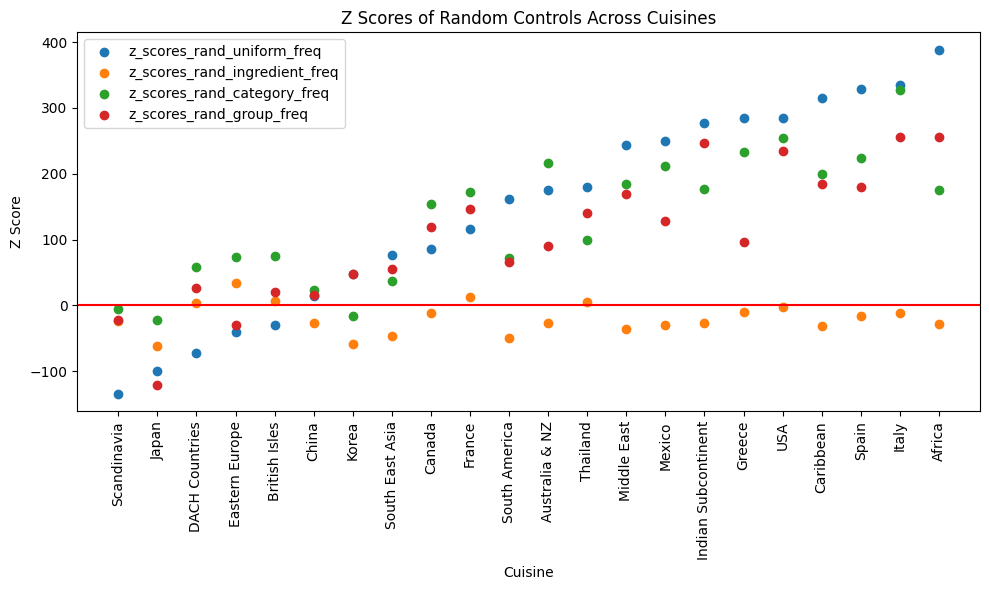

In [41]:

# Sort scores and cuisines by ascending order of scores
wxyza = list(zip(z_scores_rand_uniform_freq, z_scores_rand_ingredient_freq, z_scores_rand_category_freq, z_scores_rand_group_freq, unique_cuisine_names))
wxyza = sorted(wxyza, key=lambda x: x[0], reverse=False)

w_sorted = [w for w, x, y, z, a in wxyza]
x_sorted = [x for w, x, y, z, a in wxyza]
y_sorted = [y for w, x, y, z, a in wxyza]
z_sorted = [z for w, x, y, z, a in wxyza]
a_sorted = [a for w, x, y, z, a in wxyza]

scatter_plot(a_sorted, 
             [w_sorted, x_sorted, y_sorted, z_sorted], 
             ["z_scores_rand_uniform_freq", "z_scores_rand_ingredient_freq", "z_scores_rand_category_freq", "z_scores_rand_group_freq"],
             "Cuisine",
             "Z Score",
             "Z Scores of Random Controls Across Cuisines")

In [42]:
z_scores_stats_table = []

for i in range(len(a_sorted)):
    z_scores_stats_table.append([a_sorted[i], round(w_sorted[i],3), round(x_sorted[i],3), round(y_sorted[i],3), round(z_sorted[i],3)])
    
z_scores_stats_table_df = pd.DataFrame(z_scores_stats_table, columns=['Cuisine', "z_scores_rand_uniform_freq", "z_scores_rand_ingredient_freq", "z_scores_rand_category_freq", "z_scores_rand_group_freq"])
z_scores_stats_table_df

,Cuisine,z_scores_rand_uniform_freq,z_scores_rand_ingredient_freq,z_scores_rand_category_freq,z_scores_rand_group_freq
0,Scandinavia,-134.811,-24.312,-5.573,-21.774
1,Japan,-99.717,-61.292,-22.672,-121.674
2,DACH Countries,-72.917,2.965,58.294,25.782
3,Eastern Europe,-39.862,34.312,73.620,-30.287
4,British Isles,-29.982,6.410,74.707,20.245
5,China,14.711,-26.284,23.083,15.600
6,Korea,47.202,-58.938,-15.821,47.531
7,South East Asia,76.184,-46.969,37.597,55.166
8,Canada,86.089,-11.778,154.216,119.285
9,France,116.591,12.601,172.817,146.177


In [43]:
print("z_scores_rand_uniform_freq", sum(abs(number) for number in z_scores_rand_uniform_freq))
print("z_scores_rand_ingredient_freq", sum(abs(number) for number in z_scores_rand_ingredient_freq))
print("z_scores_rand_category_freq", sum(abs(number) for number in z_scores_rand_category_freq))
print("z_scores_rand_group_freq", sum(abs(number) for number in z_scores_rand_group_freq))


z_scores_rand_uniform_freq 3941.8785991256054
z_scores_rand_ingredient_freq 559.7503292494152
z_scores_rand_category_freq 3013.7173779917516
z_scores_rand_group_freq 2650.599248475379


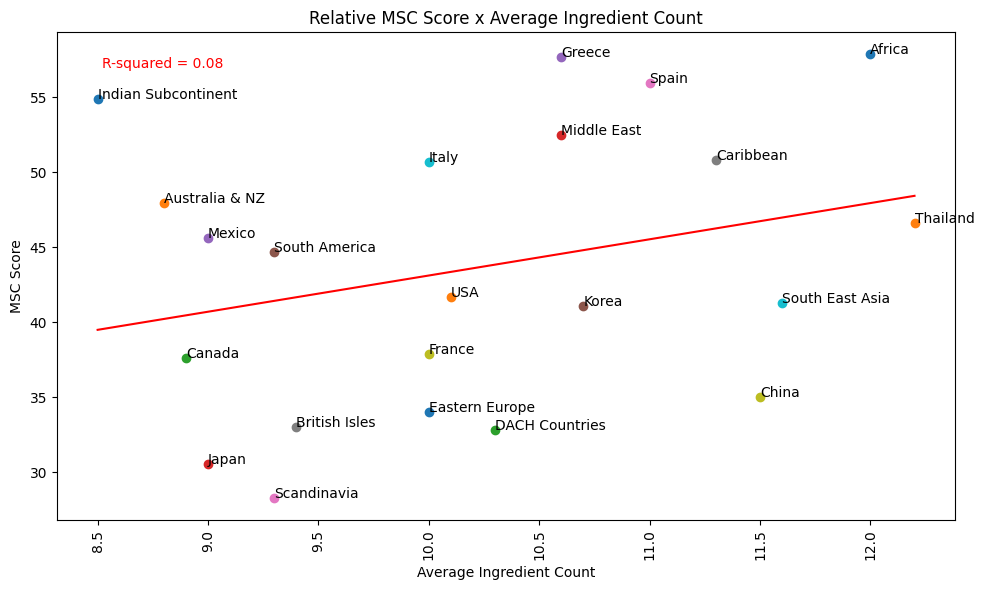

In [44]:
import numpy as np
import matplotlib.pyplot as plt

reordered_ingredient_counts = []
for cuisine_name in unique_cuisine_names:
    reordered_ingredient_counts.append(cuisine_stats_table_df[cuisine_stats_table_df["Cuisine"] == cuisine_name]['Avg Ingredient Count'].values[0])

fig, ax = plt.subplots(figsize=(10, 6))

# Sort scores and cuisines by ascending order of scores
xya = list(zip(reordered_ingredient_counts, msc_scores, unique_cuisine_names))
xya = sorted(xya, key=lambda x: x[0], reverse=False)

x_sorted = [x for x, y, a in xya]
y_sorted = [y for x, y, a in xya]
a_sorted = [a for x, y, a in xya]

for x, y in zip(x_sorted, y_sorted):
    ax.scatter(x, y)

# Perform linear regression
coefficients = np.polyfit(x_sorted, y_sorted, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Generate the regression line
regression_line = slope * np.array(x_sorted) + intercept

# Calculate R-squared
y_mean = np.mean(y_sorted)
ss_total = np.sum((y_sorted - y_mean)**2)
ss_residual = np.sum((y_sorted - regression_line)**2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the regression line and R-squared value
ax.plot(x_sorted, regression_line, color='red', label='Regression Line')
ax.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, ha='left', va='top', color='red')

for i, txt in enumerate(a_sorted):
    ax.annotate(txt, (x_sorted[i], y_sorted[i]))

ax.set_xlabel("Average Ingredient Count")
ax.set_ylabel("MSC Score")
ax.set_title("Relative MSC Score x Average Ingredient Count")

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Food Bridging

In [45]:
def construct_flavor_network(recipes, flavors_df):
    """
    Construct a flavor network based on the ingredients and their shared flavor compounds.

    Parameters:
        recipes (list of lists): List of recipes, where each recipe is a list of ingredient names.
        flavors_df (pandas.DataFrame): DataFrame containing information about flavor compounds of ingredients.

    Returns:
        networkx.Graph: A flavor network represented as a graph with ingredients as nodes and shared flavor
        compounds as weighted edges.
    """
    # Initialize an empty graph to represent the flavor network
    flavor_network = nx.Graph()

    # Create a dictionary to store each ingredient's flavor compounds
    ingredient_flavors = {}

    # Extract ingredients and their flavor compounds from recipes
    for recipe in recipes:
        for ingredient in recipe:
            if ingredient not in ingredient_flavors:
                # Check if the ingredient is in the flavors_df DataFrame
                if ingredient not in flavors_df['Entity ID'].values:
                    continue
                # Get the flavor compounds for the ingredient and store in the dictionary
                ingredient_flavors[ingredient] = flavors_df[flavors_df['Entity ID'] == ingredient]['Molecules'].values[0]

    # Add ingredients as nodes to the flavor network
    flavor_network.add_nodes_from(ingredient_flavors.keys())

    # Calculate the shared flavor compounds between ingredient pairs
    ingredient_pairs = combinations(ingredient_flavors.keys(), 2)
    shared_compounds = {}
    for pair in ingredient_pairs:
        # Find common flavor compounds between ingredient pairs
        common_compounds = ingredient_flavors[pair[0]].intersection(ingredient_flavors[pair[1]])
        shared_compounds[pair] = len(common_compounds)

    # If no shared compounds found, return an empty flavor network
    if len(shared_compounds) == 0:
        return flavor_network

    # Calculate the maximum and minimum number of shared compounds
    max_shared_compounds = max(shared_compounds.values())
    min_shared_compounds = min(shared_compounds.values())

    # Add edges with normalized weights to the flavor network
    epsilon = 0.01
    for pair, shared_count in shared_compounds.items():
        if shared_count == 0 or max_shared_compounds == min_shared_compounds:
            continue
        # Normalize the shared_count to get the edge weight
        normalized_weight = (((1 - 2 * epsilon) * shared_count + (2 * epsilon - 1) * min_shared_compounds) /
                             (max_shared_compounds - min_shared_compounds)) + epsilon
        # Add the edge to the flavor network with the normalized weight
        flavor_network.add_edge(pair[0], pair[1], weight=normalized_weight)

    # Return the constructed flavor network
    return flavor_network


In [47]:
def calculate_semimetric_percentage(graph):
    """
    Calculates the semimetric percentage of a given graph.

    Parameters:
        graph (networkx.Graph): The input graph.

    Returns:
        tuple: A tuple containing two lists - `sm` and `m`.
            `sm` (list): List of edges that have at least one shortest simple path
                         with a cost higher than the edge weight.
            `m` (list): List of edges where all shortest simple paths have lower cost than the edge weight.
    """
    m = []  # List to store edges with all shortest simple paths having lower cost
    sm = []  # List to store edges with at least one shortest simple path having higher cost
    edges = list(graph.edges)

    for edge in edges:
        source_vertex, target_vertex = edge
        weight = graph.get_edge_data(source_vertex, target_vertex)['weight']

        # Generate up to 10 shortest simple paths between the source and target vertices
        ksp_generator = nx.shortest_simple_paths(graph, source_vertex, target_vertex, weight='weight')

        for path in islice(ksp_generator, 10):
            # Calculate the total cost of the current path
            path_cost = sum(graph.get_edge_data(path[j], path[j+1])['weight'] for j in range(len(path) - 1))
            if path_cost > weight:
                # If the current path's cost is higher than the edge weight, add the edge to `sm`
                sm.append(edge)
                break
        else:
            # This is run when the for loop doesn't break, i.e., all paths have lower cost than the edge weight
            m.append(edge)

    return sm, m


#### Average over Recipes

In [49]:
def worker_func(args):
    """
    Function that calculates the semi-metric percentage score for a given recipe.

    Args:
        args: A tuple containing the recipe and flavors_df.

    Returns:
        The semi-metric percentage score for the given recipe.
    """
    recipe, flavors_df = args
    flavor_net = construct_flavor_network([recipe], flavors_df)
    sm_edges, m_edges = calculate_semimetric_percentage(flavor_net)
    numerator = len(sm_edges)
    denominator = len(m_edges) + len(sm_edges)
    return numerator / denominator if denominator != 0 else 0

def intergroup_smp_score_parallel(recipes, flavors_df, return_sd=False):
    """
    Function that calculates the average semi-metric percentage score for a list of recipes in parallel.

    Args:
        recipes (list): A list of recipes.
        flavors_df (DataFrame): The flavors DataFrame used in the calculations.
        return_sd (bool, optional): Whether to return the standard deviation. Defaults to False.

    Returns:
        float: The average semi-metric percentage score for the list of recipes.
        (optional) float: The standard deviation of the semi-metric percentage scores.
    """
    # Create a multiprocessing pool using the number of CPU cores available
    with mp.Pool(processes=mp.cpu_count()) as pool:
        # Use tqdm to show a progress bar during the calculations
        results = list(tqdm(pool.imap(worker_func, [(recipe, flavors_df) for recipe in recipes]), total=len(recipes)))

    # Filter out any None results (if any)
    valid_results = [result for result in results if result is not None]
    
    # Calculate the average semi-metric percentage score
    avg_smp_score = sum(valid_results) / len(valid_results) if valid_results else 0

    if return_sd:
        # Calculate the standard deviation if required
        return avg_smp_score, np.std(valid_results) 
    else:
        return avg_smp_score


In [50]:
# List to store SMP (Similarity Matrix Profile) scores
smp_scores = []

# Check if the file containing SMP scores already exists
if os.path.exists('exported_vectors/smp_scores.pkl'):
    # If the file exists, load the SMP scores from it
    with open('exported_vectors/smp_scores.pkl', 'rb') as file:
        smp_scores = pickle.load(file)
else:
    # If the file doesn't exist, calculate SMP scores and save them to the file
    for cuisine in unique_cuisine_names:
        # Assuming unique_cuisine_names is a list of cuisine names
        # Calculate SMP score using the intergroup_smp_score_parallel function
        avg_smp_score = intergroup_smp_score_parallel(master_recipe_df[master_recipe_df["Cuisine"] == cuisine].groupby('Recipe ID')['Entity ID'].apply(list).tolist(), flavors_df)
        # Append the SMP score to the list
        smp_scores.append(avg_smp_score)
        # Uncomment the following line if you want to print each cuisine's SMP score
        # print(cuisine, avg_smp_score)

    # Save the SMP scores list to a file for future use
    with open('exported_vectors/smp_scores.pkl', 'wb') as file:
        pickle.dump(smp_scores, file)


In [51]:
# Initialize an empty list to store the SMP scores for random cuisine names.
smp_scores_rand = []

# Check if the file 'smp_scores_rand.pkl' exists.
if os.path.exists('exported_vectors/smp_scores_rand.pkl'):
    # If the file exists, load the SMP scores from the file.
    with open('exported_vectors/smp_scores_rand.pkl', 'rb') as file:
        smp_scores_rand = pickle.load(file)
else:   
    # If the file doesn't exist, calculate the SMP scores for random cuisine names.
    for cuisine_name in unique_cuisine_names:
        # Extract nested arrays of 'Entity ID' grouped by 'Recipe ID' for each cuisine.
        nested_array = rand_uniform_df[rand_uniform_df['Cuisine'] == cuisine_name].groupby('Recipe ID')['Entity ID'].apply(list).tolist()
        
        # Calculate the average SMP score for the current cuisine using parallel processing.
        avg_smp_score = intergroup_smp_score_parallel(nested_array, flavors_df)
        
        # Append the calculated average SMP score to the list.
        smp_scores_rand.append(avg_smp_score)
        
    # Save the SMP scores for random cuisine names to a file for future use.
    with open('exported_vectors/smp_scores_rand.pkl', 'wb') as file:
        pickle.dump(smp_scores_rand, file)

# Calculate the delta between the SMP scores and the SMP scores for random cuisine names.
smp_scores_delta = list(np.subtract(smp_scores, smp_scores_rand))


In [52]:
def visualize_smp_scores(cuisines, msc_scores_sets, labels):
    """
    Visualize the relative MSC scores across cuisines using a bar chart.
    """
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

    for msc_scores_set in msc_scores_sets:
        ax.scatter(cuisines, msc_scores_set, label=labels.pop(0))

    ax.set_xlabel('Cuisine')
    ax.set_ylabel('SMP Score')
    ax.set_title('Relative SMP Scores Across Cuisines')

    plt.legend(loc='upper left')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Optimize spacing
    plt.show()

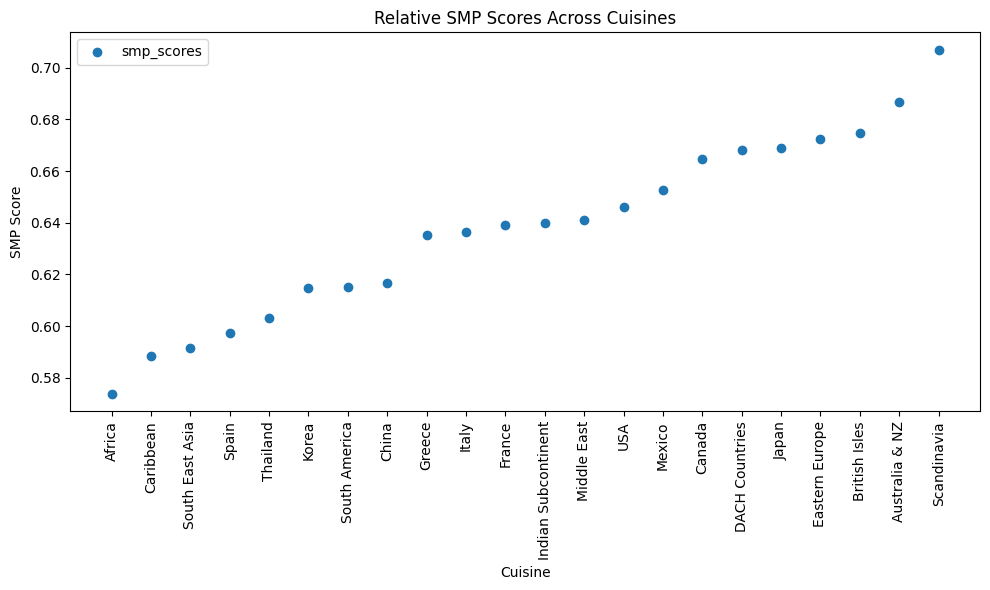

In [53]:
# Sort scores and cuisines by ascending order of scores
xy = list(zip(smp_scores, unique_cuisine_names))
xy = sorted(xy, key=lambda x: x[0], reverse=False)

x_sorted = [x for x, y in xy]
y_sorted = [y for x, y in xy]

visualize_smp_scores(y_sorted, [x_sorted], ["smp_scores"])

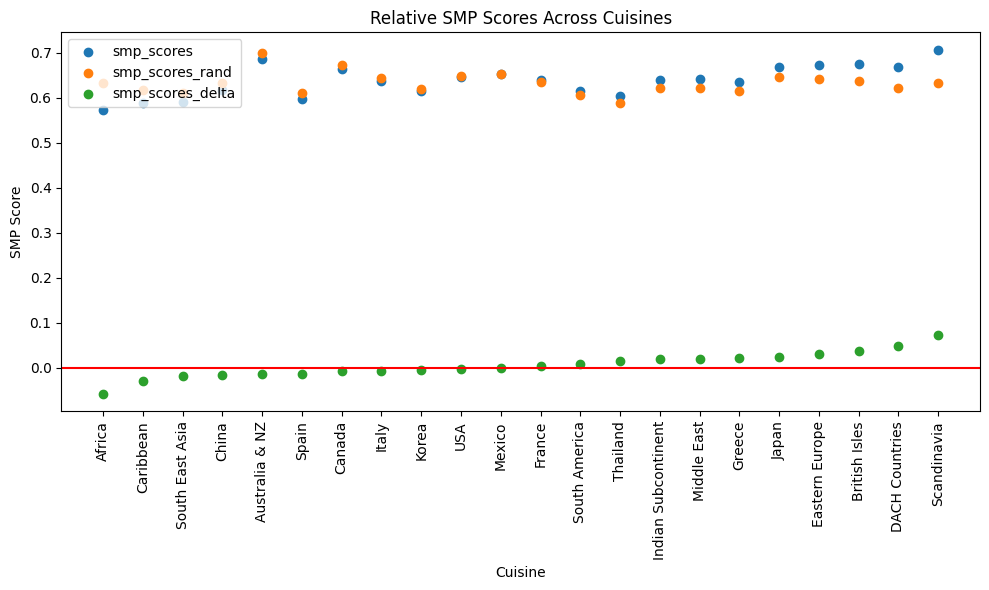

In [54]:
# Sort scores and cuisines by ascending order of scores
xyza = list(zip(smp_scores, smp_scores_rand, smp_scores_delta, unique_cuisine_names))
xyza = sorted(xyza, key=lambda x: x[2], reverse=False)

x_sorted = [x for x, y, z, a in xyza]
y_sorted = [y for x, y, z, a in xyza]
z_sorted = [z for x, y, z, a in xyza]
a_sorted = [a for x, y, z, a in xyza]

scatter_plot(a_sorted, 
             [x_sorted, y_sorted, z_sorted], 
             ["smp_scores", "smp_scores_rand", "smp_scores_delta"],
             "Cuisine",
             "SMP Score",
             "Relative SMP Scores Across Cuisines")

In [55]:
smp_stats_table = []

for i in range(len(a_sorted)):
    smp_stats_table.append([a_sorted[i], round(x_sorted[i],3), round(y_sorted[i],3), round(z_sorted[i],3)])

smp_stats_table_df = pd.DataFrame(smp_stats_table, columns=['Cuisine', "smp_scores", "smp_scores_rand", "smp_scores_delta"])
smp_stats_table_df

,Cuisine,smp_scores,smp_scores_rand,smp_scores_delta
0,Africa,0.574,0.632,-0.059
1,Caribbean,0.589,0.617,-0.029
2,South East Asia,0.591,0.610,-0.019
3,China,0.617,0.634,-0.017
4,Australia & NZ,0.687,0.700,-0.013
5,Spain,0.597,0.610,-0.013
6,Canada,0.665,0.673,-0.008
7,Italy,0.637,0.644,-0.007
8,Korea,0.615,0.620,-0.005
9,USA,0.646,0.649,-0.003


In [56]:
def calculate_smp_z_score(rand_num_recipes, cuisine_smp_score, rand_smp_score, rand_smp_sd):
    """
    Calculate the z-score for a specific cuisine's SMP (Similarity Match Percentage).

    Parameters:
        rand_num_recipes (int): The number of random recipes used for comparison.
        cuisine_smp_score (float): The SMP score of the cuisine from the original dataset.
        rand_smp_score (float): The average SMP score from random samples.
        rand_smp_sd (float): The standard deviation of SMP scores from random samples.

    Returns:
        float: The z-score representing the difference between cuisine's SMP and random samples' SMP.
    """
    return math.sqrt(rand_num_recipes) * (cuisine_smp_score - rand_smp_score) / rand_smp_sd

def calculate_smp_cuisine_z_scores(rand_df, flavors_df, smp_stats_table_df, unique_cuisine_names):
    """
    Calculate z-scores for each unique cuisine's SMP (Similarity Match Percentage).

    Parameters:
        rand_df (pandas.DataFrame): DataFrame containing random sample data.
        flavors_df (pandas.DataFrame): DataFrame containing flavors data.
        smp_stats_table_df (pandas.DataFrame): DataFrame containing SMP statistics for cuisines.
        unique_cuisine_names (list): List of unique cuisine names to calculate z-scores for.

    Returns:
        list: A list of z-scores for each cuisine.
    """
    z_scores = []
    for cuisine_name in unique_cuisine_names:
        # Extract nested_array using groupby on 'Cuisine' and apply 'list' function
        nested_array = rand_df[rand_df['Cuisine'] == cuisine_name].groupby('Recipe ID')['Entity ID'].apply(list).tolist()
        
        # Calculate the SMP score and standard deviation for random samples
        rand_smp_score, rand_smp_sd = intergroup_smp_score_parallel(nested_array, flavors_df, return_sd=True)
        
        # Calculate z-score for the cuisine and append to the z_scores list
        z_score = calculate_smp_z_score(
            NUM_RANDOM_RECIPES,
            smp_stats_table_df[smp_stats_table_df["Cuisine"] == cuisine_name]["smp_scores"].values[0],
            rand_smp_score,
            rand_smp_sd
        )
        z_scores.append(z_score)
    
    return z_scores


In [57]:
smp_z_scores_rand_uniform_freq = []
smp_z_scores_rand_ingredient_freq = []
smp_z_scores_rand_category_freq = []
smp_z_scores_rand_group_freq = []

if os.path.exists('exported_vectors/smp_z_scores_rand_uniform_freq.pkl'):
    with open('exported_vectors/smp_z_scores_rand_uniform_freq.pkl', 'rb') as file:
        smp_z_scores_rand_uniform_freq = pickle.load(file)
    with open('exported_vectors/smp_z_scores_rand_ingredient_freq.pkl', 'rb') as file:
        smp_z_scores_rand_ingredient_freq = pickle.load(file)
    with open('exported_vectors/smp_z_scores_rand_category_freq.pkl', 'rb') as file:
        smp_z_scores_rand_category_freq = pickle.load(file)
    with open('exported_vectors/smp_z_scores_rand_group_freq.pkl', 'rb') as file:
        smp_z_scores_rand_group_freq = pickle.load(file)
else:
    smp_z_scores_rand_uniform_freq = calculate_smp_cuisine_z_scores(rand_uniform_df, flavors_df, smp_stats_table_df, unique_cuisine_names)
    smp_z_scores_rand_ingredient_freq = calculate_smp_cuisine_z_scores(rand_ingredient_freq_df, flavors_df, smp_stats_table_df, unique_cuisine_names)
    smp_z_scores_rand_category_freq = calculate_smp_cuisine_z_scores(rand_category_freq_df, flavors_df, smp_stats_table_df, unique_cuisine_names)
    smp_z_scores_rand_group_freq = calculate_smp_cuisine_z_scores(rand_group_freq_df, flavors_df, smp_stats_table_df, unique_cuisine_names)
    
    # Pickle the dictionaries for later use
    with open('exported_vectors/smp_z_scores_rand_uniform_freq.pkl', 'wb') as file:
        pickle.dump(smp_z_scores_rand_uniform_freq, file)
    with open('exported_vectors/smp_z_scores_rand_ingredient_freq.pkl', 'wb') as file:
        pickle.dump(smp_z_scores_rand_ingredient_freq, file)
    with open('exported_vectors/smp_z_scores_rand_category_freq.pkl', 'wb') as file:
        pickle.dump(smp_z_scores_rand_category_freq, file)
    with open('exported_vectors/smp_z_scores_rand_group_freq.pkl', 'wb') as file:
        pickle.dump(smp_z_scores_rand_group_freq, file)
    

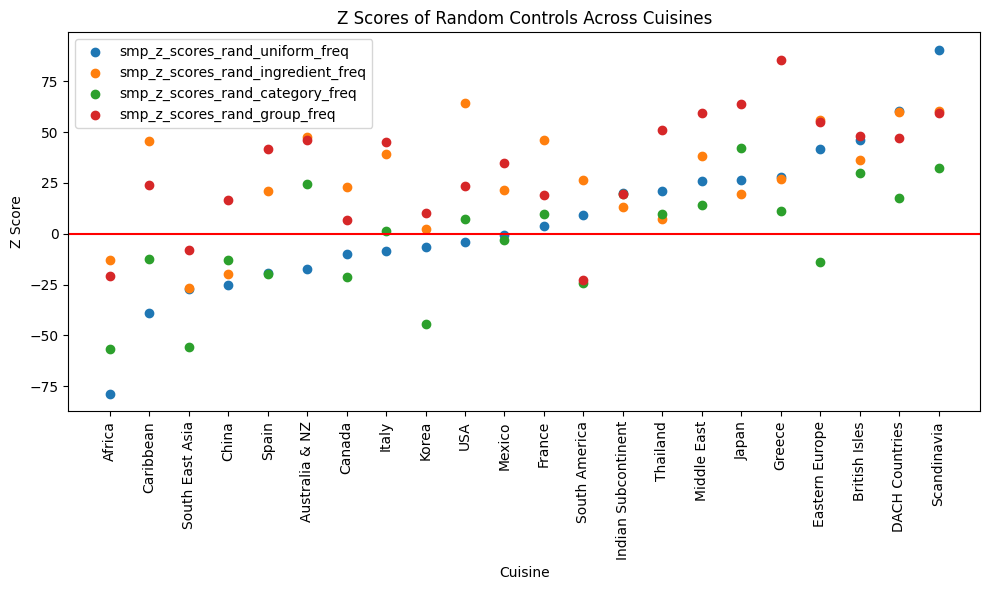

In [58]:

# Sort scores and cuisines by ascending order of scores
wxyza = list(zip(smp_z_scores_rand_uniform_freq, smp_z_scores_rand_ingredient_freq, smp_z_scores_rand_category_freq, smp_z_scores_rand_group_freq, unique_cuisine_names))
wxyza = sorted(wxyza, key=lambda x: x[0], reverse=False)

w_sorted = [w for w, x, y, z, a in wxyza]
x_sorted = [x for w, x, y, z, a in wxyza]
y_sorted = [y for w, x, y, z, a in wxyza]
z_sorted = [z for w, x, y, z, a in wxyza]
a_sorted = [a for w, x, y, z, a in wxyza]

scatter_plot(a_sorted, 
             [w_sorted, x_sorted, y_sorted, z_sorted], 
             ["smp_z_scores_rand_uniform_freq", "smp_z_scores_rand_ingredient_freq", "smp_z_scores_rand_category_freq", "smp_z_scores_rand_group_freq"],
             "Cuisine",
             "Z Score",
             "Z Scores of Random Controls Across Cuisines")

In [59]:
# Initialize an empty list to store the z-score statistics table
smp_z_scores_stats_table = []

# Iterate through the sorted list 'a_sorted' and append each row of z-score statistics to the 'smp_z_scores_stats_table'
for i in range(len(a_sorted)):
    smp_z_scores_stats_table.append([
        a_sorted[i],                       # The 'Cuisine' column, containing values from 'a_sorted'
        round(w_sorted[i], 3),             # Rounded value of 'w_sorted' at index 'i'
        round(x_sorted[i], 3),             # Rounded value of 'x_sorted' at index 'i'
        round(y_sorted[i], 3),             # Rounded value of 'y_sorted' at index 'i'
        round(z_sorted[i], 3)              # Rounded value of 'z_sorted' at index 'i'
    ])

# Create a pandas DataFrame using the 'smp_z_scores_stats_table' list and specify column names
smp_z_scores_stats_table_df = pd.DataFrame(smp_z_scores_stats_table, columns=[
    'Cuisine',                           # Column representing the cuisine names
    "smp_z_scores_rand_uniform_freq",     # Column representing the z-score for random uniform frequency
    "smp_z_scores_rand_ingredient_freq",  # Column representing the z-score for random ingredient frequency
    "smp_z_scores_rand_category_freq",    # Column representing the z-score for random category frequency
    "smp_z_scores_rand_group_freq"        # Column representing the z-score for random group frequency
])


,Cuisine,smp_z_scores_rand_uniform_freq,smp_z_scores_rand_ingredient_freq,smp_z_scores_rand_category_freq,smp_z_scores_rand_group_freq
0,Africa,-78.899,-12.710,-56.563,-20.893
1,Caribbean,-38.893,45.534,-12.488,24.242
2,South East Asia,-27.005,-26.731,-55.854,-7.747
3,China,-25.131,-19.958,-12.798,16.497
4,Spain,-19.180,21.080,-19.881,41.497
5,Australia & NZ,-17.444,47.618,24.572,46.054
6,Canada,-9.820,23.079,-21.022,6.988
7,Italy,-8.465,39.440,1.533,44.942
8,Korea,-6.462,2.578,-44.229,10.182
9,USA,-4.129,64.278,7.435,23.534


In [60]:
print("smp_z_scores_rand_uniform_freq", sum(abs(number) for number in smp_z_scores_rand_uniform_freq))
print("smp_z_scores_rand_ingredient_freq", sum(abs(number) for number in smp_z_scores_rand_ingredient_freq))
print("smp_z_scores_rand_category_freq", sum(abs(number) for number in smp_z_scores_rand_category_freq))
print("smp_z_scores_rand_group_freq", sum(abs(number) for number in smp_z_scores_rand_group_freq))


smp_z_scores_rand_uniform_freq 610.3810176040718
smp_z_scores_rand_ingredient_freq 714.2835517042594
smp_z_scores_rand_category_freq 483.93852186444894
smp_z_scores_rand_group_freq 809.5587399602215


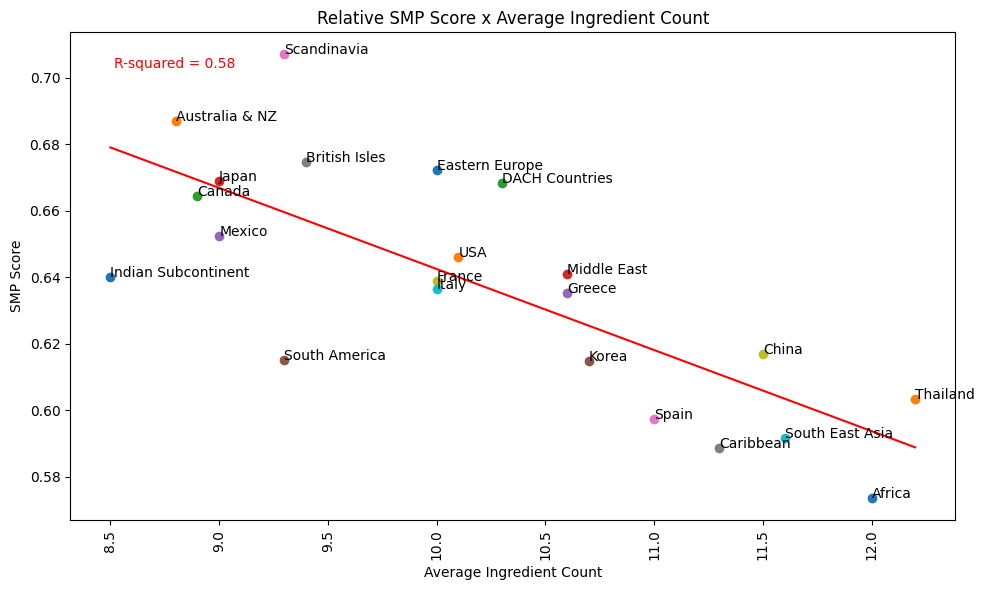

In [61]:
import numpy as np
import matplotlib.pyplot as plt

reordered_ingredient_counts = []
for cuisine_name in unique_cuisine_names:
    reordered_ingredient_counts.append(cuisine_stats_table_df[cuisine_stats_table_df["Cuisine"] == cuisine_name]['Avg Ingredient Count'].values[0])

fig, ax = plt.subplots(figsize=(10, 6))

# Sort scores and cuisines by ascending order of scores
xya = list(zip(reordered_ingredient_counts, smp_scores, unique_cuisine_names))
xya = sorted(xya, key=lambda x: x[0], reverse=False)

x_sorted = [x for x, y, a in xya]
y_sorted = [y for x, y, a in xya]
a_sorted = [a for x, y, a in xya]

for x, y in zip(x_sorted, y_sorted):
    ax.scatter(x, y)

# Perform linear regression
coefficients = np.polyfit(x_sorted, y_sorted, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Generate the regression line
regression_line = slope * np.array(x_sorted) + intercept

# Calculate R-squared
y_mean = np.mean(y_sorted)
ss_total = np.sum((y_sorted - y_mean)**2)
ss_residual = np.sum((y_sorted - regression_line)**2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the regression line and R-squared value
ax.plot(x_sorted, regression_line, color='red', label='Regression Line')
ax.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, ha='left', va='top', color='red')

for i, txt in enumerate(a_sorted):
    ax.annotate(txt, (x_sorted[i], y_sorted[i]))

ax.set_xlabel("Average Ingredient Count")
ax.set_ylabel("SMP Score")
ax.set_title("Relative SMP Score x Average Ingredient Count")

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


### Combined

In [62]:
def visualize_combined_scores(cuisines, msc_scores, smp_scores):

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

    ax.scatter(msc_scores, smp_scores)

    ax.set_xlabel('MSC Score')
    ax.set_ylabel('SMP Score')
    ax.set_title('Food-Pairing versus Food-Bridging')
    
    for i, txt in enumerate(cuisines):
        ax.annotate(txt, (msc_scores[i], smp_scores[i]))

    plt.tight_layout()  # Optimize spacing
    plt.show()

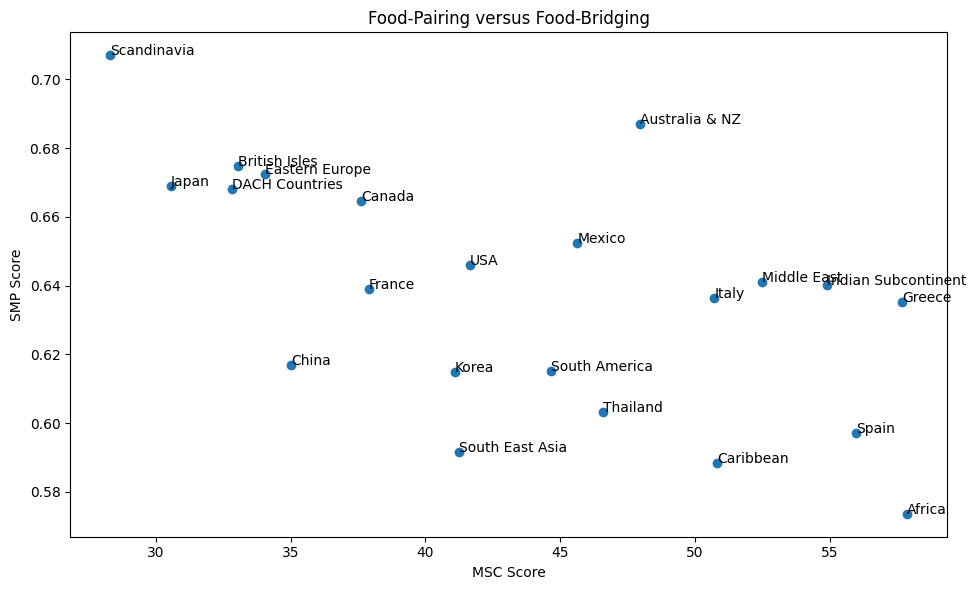

In [63]:
visualize_combined_scores(unique_cuisine_names, msc_scores, smp_scores)

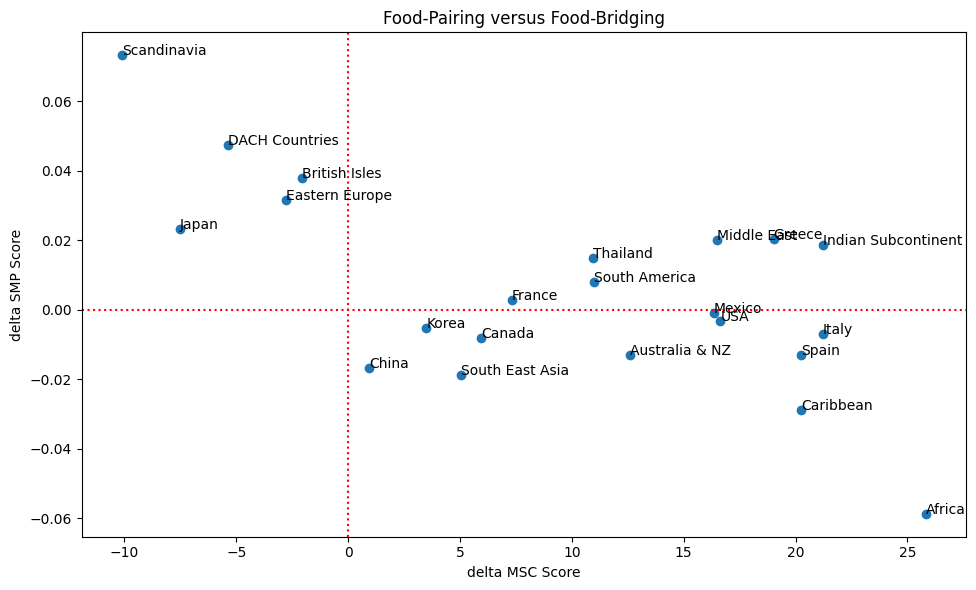

In [65]:
def visualize_combined_scores(cuisines, msc_scores, smp_scores):

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

    ax.scatter(msc_scores, smp_scores)

    ax.set_xlabel('delta MSC Score')
    ax.set_ylabel('delta SMP Score')
    ax.set_title('Food-Pairing versus Food-Bridging')
    
    for i, txt in enumerate(cuisines):
        ax.annotate(txt, (msc_scores[i], smp_scores[i]))
        
    ax.axhline(0, color='r', linestyle='dotted')
    ax.axvline(0, color='r', linestyle='dotted')

    plt.tight_layout()  # Optimize spacing
    plt.show()
visualize_combined_scores(unique_cuisine_names, msc_scores_delta, smp_scores_delta)

## Higher Order Analysis

### Food Pairing Analysis

In [86]:
def generate_combinations(recipes, set_size):
    """
    Generate combinations of items from a list of recipes using FP-Growth algorithm.

    Parameters:
        recipes (list of lists): A list of transactional data where each inner list represents a recipe.
        set_size (int): The size of the combinations to generate.

    Returns:
        list: A list of combinations of items with the specified set size.
    """

    # Step 1: Convert the list of recipes into a binary encoded DataFrame using TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit_transform(recipes)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Step 2: Use FP-Growth to find frequent itemsets with the specified minimum support and maximum length
    frequent_itemsets = fpgrowth(df, min_support=0.001, use_colnames=True, max_len=set_size)

    # Step 3: Extract combinations of the desired set size from the frequent itemsets
    combinations_list = []
    for itemset in frequent_itemsets[frequent_itemsets["itemsets"].map(len) == set_size]["itemsets"]:
        combinations_list.append(list(itemset))

    return combinations_list

# Example usage:
# recipes = [['apple', 'banana', 'pear'], ['banana', 'orange'], ['apple', 'pear', 'grape']]
# set_size = 2
# result = generate_combinations(recipes, set_size)
# print(result)


In [87]:
tuple_msc_scores = {}  # Dictionary to store msc scores for each cuisine
tuple_msc_sd = {}  # Dictionary to store standard deviations for each cuisine

# Check if pickle files exist, if yes, load the data, else compute and save the data
if os.path.exists('exported_vectors/tuple_msc_scores.pkl'):
    with open('exported_vectors/tuple_msc_scores.pkl', 'rb') as file:
        tuple_msc_scores = pickle.load(file)
    with open('exported_vectors/tuple_msc_sd.pkl', 'rb') as file:
        tuple_msc_sd = pickle.load(file)
else:
    for cuisine_name in unique_cuisine_names:
        cuisine_msc_scores = {}  # Dictionary to store msc scores for each set size
        cuisine_msc_sd = {}  # Dictionary to store standard deviations for each set size
        
        # Compute msc scores for different set sizes (ranging from 3 to 6)
        for set_size in range(3, 7):
            print(cuisine_name + " - " + str(set_size))
            
            # Get recipes belonging to the current cuisine
            recipes = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name]['Entity ID'].apply(list).tolist()
            
            # Generate all possible combinations of recipes for the current set size
            tuple_combinations = generate_combinations(recipes, set_size)
            print(len(tuple_combinations))
            
            # Calculate msc score and standard deviation for the generated combinations
            msc_score, sd = intergroup_msc_score(tuple_combinations, flavors_df, return_sd=True, use_index=True)
            
            # Store the msc score and standard deviation for the current set size
            cuisine_msc_scores[set_size] = msc_score
            cuisine_msc_sd[set_size] = sd
            
            del tuple_combinations  # Free up memory
            
        # Store the msc scores and standard deviations for the current cuisine
        tuple_msc_scores[cuisine_name] = cuisine_msc_scores
        tuple_msc_sd[cuisine_name] = cuisine_msc_sd
    
    # Pickle the dictionaries for future use
    with open('exported_vectors/tuple_msc_scores.pkl', 'wb') as file:
        pickle.dump(tuple_msc_scores, file)
    with open('exported_vectors/tuple_msc_sd.pkl', 'wb') as file:
        pickle.dump(tuple_msc_sd, file)


In [88]:
for cuisine_name in unique_cuisine_names:
    for set_size in range(3, 7):
        print(cuisine_name,set_size,tuple_msc_scores[cuisine_name][set_size],tuple_msc_sd[cuisine_name][set_size])

Indian Subcontinent 3 57.72751661484046 44.031693926321324
Indian Subcontinent 4 61.443671320904215 38.7648601961122
Indian Subcontinent 5 65.1117054661389 34.394635791225866
Indian Subcontinent 6 68.67042032373388 30.973930170393754
Africa 3 55.623165358976756 43.38831262025601
Africa 4 58.63962011792984 37.719297712688196
Africa 5 60.280867538194464 32.98566493850914
Africa 6 61.13141251115743 29.364928209166553
China 3 39.241967317434536 38.05933589422074
China 4 38.956325218083585 31.664902480594638
China 5 38.68434744555606 27.180712513048103
China 6 38.54077133313656 24.106304237825228
Thailand 3 48.347925910275684 41.71302358096274
Thailand 4 49.73656823187723 35.84207621304352
Thailand 5 51.055860559023046 31.460163214584693
Thailand 6 52.75075794431853 28.322390759742397
South East Asia 3 48.43328554404177 42.166367805453234
South East Asia 4 49.34355478926857 35.94017378551823
South East Asia 5 49.74954059502102 31.284900879888216
South East Asia 6 49.855590102773 27.93505060

In [89]:
""" # Will take forever to run - we need to skip this. 510m for just Indian Subcontinent - 3 grams
# Define a dictionary to store the similarity scores for tuples
tuple_smp_scores = {}

# Check if the pickle file containing previously computed scores exists
if os.path.exists('exported_vectors/tuple_smp_scores.pkl'):
    # If the file exists, load the data into the 'tuple_smp_scores' dictionary
    with open('exported_vectors/tuple_smp_scores.pkl', 'rb') as file:
        tuple_smp_scores = pickle.load(file)
else:
    # If the file does not exist, compute similarity scores for each cuisine and set size
    for cuisine_name in unique_cuisine_names:
        # Initialize a dictionary to store similarity scores for different set sizes
        cuisine_smp_scores = {}
        for set_size in range(3, 7):
            print(cuisine_name + " - " + str(set_size))
            
            # Get a list of recipes belonging to the current cuisine
            recipes = master_recipe_df[master_recipe_df['Cuisine'] == cuisine_name]['Entity ID'].apply(list).tolist()
            
            # Generate all possible combinations of recipes for the given set size
            tuple_combinations = generate_combinations(recipes, set_size, True)
            
            # Calculate the similarity score for the generated combinations in parallel
            smp_score = intergroup_smp_score_parallel(tuple_combinations, flavors_df)
            
            # Store the similarity score in the cuisine_smp_scores dictionary
            cuisine_smp_scores[set_size] = smp_score
        
        # Store the cuisine_smp_scores dictionary in the main tuple_smp_scores dictionary
        tuple_smp_scores[cuisine_name] = cuisine_smp_scores
    
    # Pickle the dictionary to save the computed similarity scores for future use
    with open('exported_vectors/tuple_smp_scores.pkl', 'wb') as file:
        pickle.dump(tuple_smp_scores, file)"""

' # Will take forever to run - we need to skip this. 510m for just Indian Subcontinent - 3 grams\ntuple_smp_scores = {}\n\nif os.path.exists(\'exported_vectors/tuple_smp_scores.pkl\'):\n    with open(\'exported_vectors/tuple_smp_scores.pkl\', \'rb\') as file:\n        tuple_smp_scores = pickle.load(file)\nelse:\n    for cuisine_name in unique_cuisine_names:\n        cuisine_smp_scores = {}\n        for set_size in range(3, 7):\n            print(cuisine_name + " - " + str(set_size))\n            recipes = master_recipe_df[master_recipe_df[\'Cuisine\'] == cuisine_name].groupby(\'Recipe ID\')[\'Entity ID\'].apply(list).tolist()\n            tuple_combinations = generate_combinations(recipes, set_size, True)\n            smp_score = intergroup_smp_score_parallel(tuple_combinations, flavors_df)\n            cuisine_smp_scores[set_size] = smp_score\n        tuple_smp_scores[cuisine_name] = cuisine_smp_scores\n    \n    # Pickle the dictionary\n    with open(\'exported_vectors/tuple_smp_scor

In [90]:
import numpy as np
from scipy.stats import norm

# Define functions for retrieving parent scores and deltas

def apply_parent_msc_score(cuisine):
    # Get the parent msc_score for the given cuisine from the DataFrame
    return msc_stats_table_df[msc_stats_table_df["Cuisine"] == cuisine]["msc_scores"].values[0]

def apply_parent_msc_score_delta(cuisine):
    # Get the parent msc_score_delta for the given cuisine from the DataFrame
    msc_scores_delta = msc_stats_table_df[msc_stats_table_df["Cuisine"] == cuisine]["msc_scores_delta"].values[0]
    return 1 if msc_scores_delta > 0 else -1

def apply_parent_smp_score(cuisine):
    # Get the parent smp_score for the given cuisine from the DataFrame
    return smp_stats_table_df[smp_stats_table_df["Cuisine"] == cuisine]["smp_scores"].values[0]

def apply_parent_smp_score_delta(cuisine):
    # Get the parent smp_score_delta for the given cuisine from the DataFrame
    smp_scores_delta = smp_stats_table_df[smp_stats_table_df["Cuisine"] == cuisine]["smp_scores_delta"].values[0]
    return 1 if smp_scores_delta > 0 else -1

# Function to find the percentile of a value given mean and standard deviation

def find_percentile(value, mean, std_dev):
    # Calculate the z-score
    z_score = (value - mean) / std_dev
    # Calculate the percentile using the cumulative distribution function of the standard normal distribution
    percentile = norm.cdf(z_score) * 100
    return percentile

# Function to calculate the msc_score for a set of ingredients

def apply_msc_score(ingredients):
    try:
        # Calculate the mean shared compounds score using the provided ingredients and flavors DataFrame
        return round(mean_shared_compounds(ingredients, flavors_df, use_index=True), 1)
    except:
        # Return 0.0 if an exception occurs during the calculation
        return 0.0

# Function to calculate the percentile of the msc_score for a given cuisine and set of ingredients

def apply_avg_msc_score_percentile(cuisine, ingredients, msc_score):
    # Retrieve mean and standard deviation for the given cuisine and number of ingredients
    percentile = find_percentile(msc_score, tuple_msc_scores[cuisine][len(ingredients)], tuple_msc_sd[cuisine][len(ingredients)])
    return round(percentile, 1)

# Function to map ingredient names to their corresponding entity IDs

def apply_entity_ids(ingredients):
    entity_ids = []

    for ingredient in ingredients:
        # Check if the ingredient is present in the flavors DataFrame
        matching_rows = flavors_df[flavors_df['Aliased Ingredient Name'] == ingredient]
        if matching_rows.empty:
            continue
        # Get the entity ID of the ingredient and add it to the list
        entity_id = matching_rows['Entity ID'].values[0]
        entity_ids.append(entity_id)

    return entity_ids

# Function to calculate the smp_score for a list of ingredient IDs

def apply_smp_score(ingredient_ids):
    # Construct the flavor network using the ingredient IDs and flavors DataFrame
    flavor_net = construct_flavor_network([ingredient_ids], flavors_df)
    # Calculate the smp_score as the ratio of semimetric edges to metric edges
    sm_edges, m_edges = calculate_semimetric_percentage(flavor_net)
    smp_score = len(sm_edges) / len(m_edges) if len(m_edges) != 0 else 0.0
    return smp_score

# Functions to lookup categories and groups for a given itemset of ingredients

def apply_lookup_categories(itemset):
    categories = []
    for ingredient_name in itemset:
        # Get the category of the ingredient from the master_recipe_df DataFrame and add it to the list
        categories.append(master_recipe_df[master_recipe_df["Aliased Ingredient Name"] == ingredient_name]["Category"].values[0])
    return tuple(categories)

def apply_lookup_groups(itemset):
    groups = []
    for ingredient_name in itemset:
        # Get the group of the ingredient from the master_recipe_df DataFrame and add it to the list
        groups.append(master_recipe_df[master_recipe_df["Aliased Ingredient Name"] == ingredient_name]["Group"].values[0])
    return tuple(groups)

# Function to retrieve the tuple_msc_score for a given cuisine and itemset

def apply_tuple_msc_score(cuisine, itemset):
    return tuple_msc_scores[cuisine][len(itemset)]


#### Each Cusine

### Frequent Itemsets

In [93]:
# Check if the pickle file exists. If it does, load the DataFrame from the pickle file.
# If not, create a new DataFrame and process the data.
stats_table_df = None
if os.path.exists('exported_vectors/stats_table_df.pkl'):
    with open('exported_vectors/stats_table_df.pkl', 'rb') as file:
        stats_table_df = pickle.load(file)
else:
    # Define the number of most common itemsets to extract
    MOST_COMMON = 5
    cuisine_itemsets = {}  # A dictionary to store frequent itemsets for each cuisine
    stats_table_df = pd.DataFrame(columns=['N-tuple', 'Cuisine', 'Support', 'Itemset'])

    # Loop through unique cuisine names and process each cuisine's data
    for cuisine_name in unique_cuisine_names:
        # Get the transactions (lists of items) for the current cuisine
        transactions = master_recipe_df[master_recipe_df["Cuisine"] == cuisine_name].groupby('Recipe ID')['Aliased Ingredient Name'].apply(list).tolist()
        
        # Convert the transactions into a binary transaction matrix
        te = TransactionEncoder()
        te_ary = te.fit_transform(transactions)
        df = pd.DataFrame(te_ary, columns=te.columns_)

        # Extract frequent itemsets using FP-Growth algorithm with minimum support of 0.05
        frequent_itemsets = fpgrowth(df, min_support=0.05, use_colnames=True, max_len=None)
        cuisine_itemsets[cuisine_name] = frequent_itemsets
        
        # Process and add the frequent itemsets to the stats_table_df DataFrame
        for n in range(3, 7):
            results = frequent_itemsets.loc[frequent_itemsets['itemsets'].map(len) == n].sort_values(by=['support'], ascending=False)
            results['Cuisine'] = cuisine_name
            results['N-tuple'] = n
            stats_table_df = pd.concat([stats_table_df, results], ignore_index=True)
    
    # Apply additional calculations and transformations to the DataFrame
    stats_table_df["Entity Ids"] = stats_table_df["Itemset"].apply(apply_entity_ids)
    stats_table_df["MSC Score"] = stats_table_df["Entity Ids"].apply(apply_msc_score)
    stats_table_df["Avg MSC Z Score"] = stats_table_df.apply(lambda x: apply_avg_msc_score_percentile(x['Cuisine'], x['Itemset'], x['MSC Score']), axis=1)
    stats_table_df['Itemset Categories'] = stats_table_df['Itemset'].apply(apply_lookup_categories)
    stats_table_df['Itemset Groups'] = stats_table_df['Itemset'].apply(apply_lookup_groups)
    stats_table_df["SMP Score"] = stats_table_df["Entity Ids"].apply(apply_smp_score)
    stats_table_df["Tuple MSC Score"] = stats_table_df.apply(lambda x: apply_tuple_msc_score(x['Cuisine'], x['Itemset']), axis=1)
    stats_table_df["Parent MSC Score"] = stats_table_df['Cuisine'].apply(apply_parent_msc_score)
    stats_table_df["Parent MSC Score Delta"] = stats_table_df['Cuisine'].apply(apply_parent_msc_score_delta)
    stats_table_df["Parent SMP Score"] = stats_table_df['Cuisine'].apply(apply_parent_smp_score)
    stats_table_df["Parent SMP Score Delta"] = stats_table_df['Cuisine'].apply(apply_parent_smp_score_delta)
    stats_table_df = stats_table_df.rename({'Support': 'Support', 'Itemset': 'Itemset'}, axis=1)
    
    # Pickle the dataframe for future use
    with open('exported_vectors/stats_table_df.pkl', 'wb') as file:
        pickle.dump(stats_table_df, file)


In [94]:
stats_table_df.to_csv("stats_table.csv", index=False)

In [95]:
# Let's start by analyzing the most common ingredient combinations across all cuisines.
# For this, we'll use the 'Support' column, which represents the frequency of the combination in the cuisine.

# Top 10 most common ingredient combinations across all cuisines
top_combinations_all = stats_table_df.sort_values('Support', ascending=False).head(10)

# Similarly, let's find out the most common ingredient combinations within each cuisine.
top_combinations_each_cuisine = stats_table_df.sort_values('Support', ascending=False).groupby('Cuisine').head(10)

top_combinations_all, top_combinations_each_cuisine

(     N-tuple         Cuisine   Support                      Itemset  \
 2202       3           Korea  0.388704  (soy sauce, sesame, garlic)   
 2203       3           Korea  0.342193  (soy sauce, sesame, pepper)   
 4214       3     Scandinavia  0.341584       (sugar, flour, butter)   
 2204       3           Korea  0.332226     (sesame, garlic, pepper)   
 2205       3           Korea  0.332226   (sugar, soy sauce, sesame)   
 2206       3           Korea  0.328904  (soy sauce, garlic, pepper)   
 2207       3           Korea  0.322259   (sugar, soy sauce, garlic)   
 2208       3           Korea  0.318937      (sugar, sesame, garlic)   
 4215       3     Scandinavia  0.304455          (sugar, flour, egg)   
 3344       3  DACH Countries  0.299795          (sugar, flour, egg)   
 
            Entity Ids  MSC Score  Avg MSC Z Score  \
 2202       [259, 299]       98.0             92.3   
 2203       [299, 339]       95.0             91.1   
 4214   [60, 920, 781]        3.7           

In [96]:
# Let's look at correlations between the different scores
correlation_matrix = stats_table_df[['MSC Score', 'SMP Score', 'Tuple MSC Score', 'Parent MSC Score', 'Parent SMP Score']].corr('spearman')

correlation_matrix

,MSC Score,SMP Score,Tuple MSC Score,Parent MSC Score,Parent SMP Score
MSC Score,1.000000,0.118873,0.400328,0.506048,-0.334535
SMP Score,0.118873,1.000000,0.044200,-0.043123,0.089291
Tuple MSC Score,0.400328,0.044200,1.000000,0.853168,-0.495040
Parent MSC Score,0.506048,-0.043123,0.853168,1.000000,-0.699593
Parent SMP Score,-0.334535,0.089291,-0.495040,-0.699593,1.000000


In [97]:
# Group the data by the itemset and calculate the total support for each one
itemset_support = stats_table_df.groupby('Itemset')['Support'].sum()

# Calculate the average MSC Z Score for each itemset
average_msc_z_score = stats_table_df.groupby('Itemset')['Avg MSC Z Score'].mean()

# Combine the two dataframes
itemset_df = pd.concat([itemset_support, average_msc_z_score], axis=1)
itemset_df.columns = ['Support Sum', 'Average MSC Z Score']

# Sort the itemsets by their total support and take the top 10
top_10_itemsets = itemset_df.sort_values(by='Support Sum', ascending=False).head(10)

top_10_itemsets


,Support Sum,Average MSC Z Score
Itemset,,
"(onion, garlic, pepper)",2.251677,91.772222
"(salt, garlic, pepper)",2.113600,37.611765
"(onion, salt, pepper)",1.853193,35.850000
"(olive, garlic, pepper)",1.820229,89.058333
"(onion, salt, garlic)",1.747947,42.423529
"(onion, olive, garlic)",1.565498,91.050000
"(sugar, flour, egg)",1.510941,14.677778
"(flour, butter, egg)",1.509926,19.060000
"(salt, olive, garlic)",1.505524,35.490909


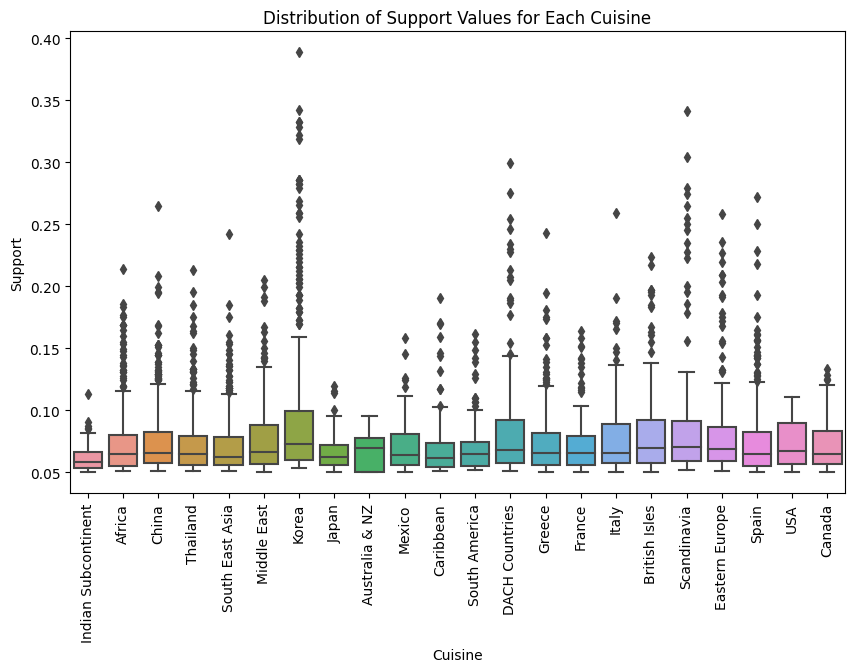

In [99]:
# Plotting the distribution of Support values for each Cuisine
plt.figure(figsize=(10,6))
sns.boxplot(x='Cuisine', y='Support', data=stats_table_df)
plt.xticks(rotation=90)
plt.title('Distribution of Support Values for Each Cuisine')
plt.show()


/var/folders/tk/3mpzsdc17flggsprn40wq3380000gn/T/ipykernel_69758/2144686567.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = n_tuple_counts.pivot('Cuisine', 'N-tuple', 'counts').fillna(0)


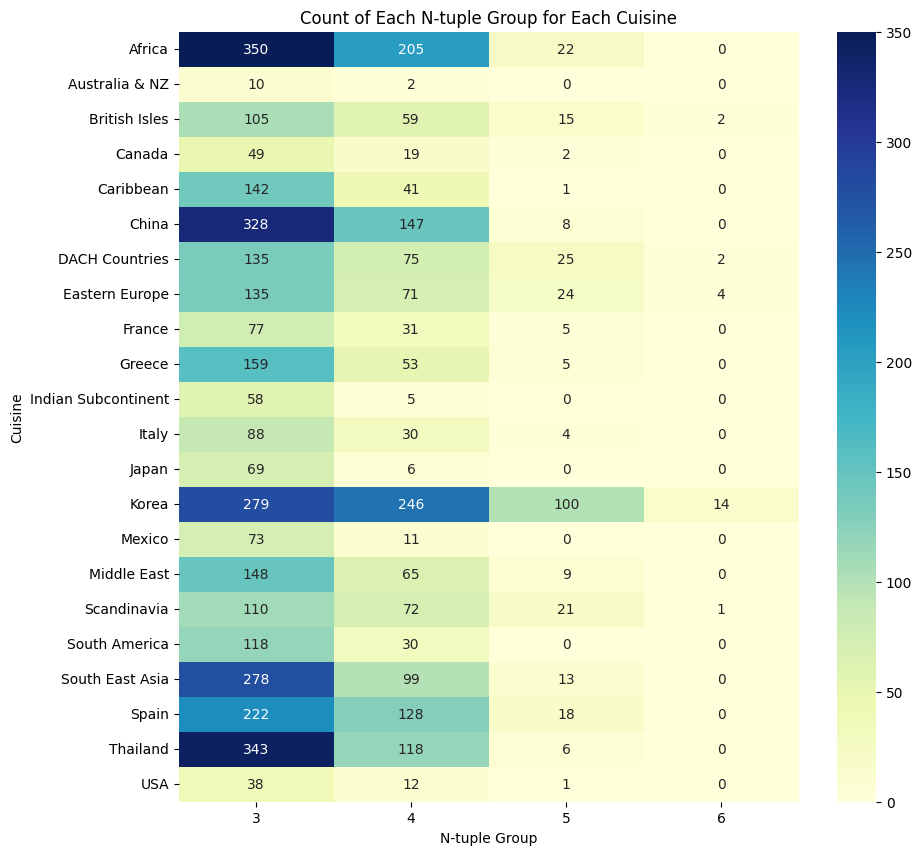

In [100]:
# Calculate the count of each N-tuple group for each cuisine
n_tuple_counts = stats_table_df.groupby(['Cuisine', 'N-tuple']).size().reset_index(name='counts')

# Create a pivot table for better visualization
pivot_table = n_tuple_counts.pivot('Cuisine', 'N-tuple', 'counts').fillna(0)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Count of Each N-tuple Group for Each Cuisine')
plt.xlabel('N-tuple Group')
plt.ylabel('Cuisine')
plt.show()


In [101]:
stats_table_df.groupby(['Cuisine']).size()

Cuisine
Africa                 577
Australia & NZ          12
British Isles          181
Canada                  70
Caribbean              184
China                  483
DACH Countries         237
Eastern Europe         234
France                 113
Greece                 217
Indian Subcontinent     63
Italy                  122
Japan                   75
Korea                  639
Mexico                  84
Middle East            222
Scandinavia            204
South America          148
South East Asia        390
Spain                  368
Thailand               467
USA                     51
dtype: int64

#### Classification

In [102]:
# Check the number of unique values and missing values in the target columns
parent_msc_delta_unique = stats_table_df['Parent MSC Score Delta'].nunique()
parent_smp_delta_unique = stats_table_df['Parent SMP Score Delta'].nunique()

parent_msc_delta_missing = stats_table_df['Parent MSC Score Delta'].isna().sum()
parent_smp_delta_missing = stats_table_df['Parent SMP Score Delta'].isna().sum()

# Check the distribution of the target columns
parent_msc_delta_distribution = stats_table_df['Parent MSC Score Delta'].value_counts(normalize=True)
parent_smp_delta_distribution = stats_table_df['Parent SMP Score Delta'].value_counts(normalize=True)

parent_msc_delta_unique, parent_smp_delta_unique, parent_msc_delta_missing, parent_smp_delta_missing, parent_msc_delta_distribution, parent_smp_delta_distribution


(2,
 2,
 0,
 0,
  1    0.818907
 -1    0.181093
 Name: Parent MSC Score Delta, dtype: float64,
 -1    0.579654
  1    0.420346
 Name: Parent SMP Score Delta, dtype: float64)

In [103]:
# Define conditions
conditions = [
    (stats_table_df['Parent MSC Score Delta'] == 1) & (stats_table_df['Parent SMP Score Delta'] == 1),
    (stats_table_df['Parent MSC Score Delta'] == 1) & (stats_table_df['Parent SMP Score Delta'] == -1),
    (stats_table_df['Parent MSC Score Delta'] == -1) & (stats_table_df['Parent SMP Score Delta'] == 1),
    (stats_table_df['Parent MSC Score Delta'] == -1) & (stats_table_df['Parent SMP Score Delta'] == -1)
]

# Define choices
choices = [1, 2, 3, 4]

# Create new column
stats_table_df['Parent Class'] = np.select(conditions, choices)

##### Based on Tuple

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

# Define columns to drop
drop_columns = ["Cuisine",
    "Parent MSC Score Delta", 
    "Parent SMP Score Delta", 
    "Itemset", 
    "Entity Ids", 
    "Itemset Categories", 
    "Itemset Groups",
    "Parent MSC Score",
    "Parent SMP Score",
    "Tuple MSC Score",
    "Avg MSC Z Score",
    'Parent Class',
    'N-tuple',
    'Support']

features = stats_table_df.drop(columns=drop_columns)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        #('num', StandardScaler(), features.select_dtypes(include=['int64', 'float64']).columns),
        #('cat', OneHotEncoder(), ['Cuisine'])
    ])



n_tuples = stats_table_df['N-tuple'].unique()

# Define targets
targets = ["Parent MSC Score Delta", "Parent SMP Score Delta"]

trained_classifiers_targets = {}
trained_classifiers_xtrain = {}
trained_classifiers_ytrain = {}
    
# Loop over each unique target and n_tuple
for target in targets:
    
    temp_target = {}
    temp_xtrain = {}
    temp_ytrain = {}
    
    for n_tuple in n_tuples:
        
        # Create lists to store the scores for each fold
        precision_scores = []
        recall_scores = []
        f1_scores = []

        # Split the data by target and n_tuple
        data = stats_table_df[stats_table_df['N-tuple'] == n_tuple]

        # Create a StratifiedKFold object
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Define classifier
        classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)

        # Define pipeline
        clf = Pipeline(steps=[
            #('preprocessor', preprocessor),
            ('classifier', classifier)
        ])

        # Loop over each split
        for train_index, test_index in skf.split(data, data[target]):
            
            # Split the data
            X_train, X_test = data.iloc[train_index], data.iloc[test_index]
            y_train, y_test = X_train[target], X_test[target]
            
            # Balance the training data
            X_train_pos = X_train[y_train == 1]
            X_train_neg = X_train[y_train == -1]
            if target == "Parent SMP Score Delta":
                X_train_balanced = pd.concat([X_train_pos.sample(len(X_train_neg), random_state=42, replace=True), X_train_neg])
            else:
                X_train_balanced = pd.concat([X_train_pos.sample(len(X_train_neg), random_state=42, replace=False), X_train_neg])
            y_train_balanced = y_train[X_train_balanced.index]
            
            # Drop unnecessary columns
            X_train = X_train_balanced.drop(columns=drop_columns)
            X_test = X_test.drop(columns=drop_columns)
            
            # Fit the model
            clf.fit(X_train, y_train_balanced)
            
            # Make predictions
            y_pred = clf.predict(X_test)
            
            # Compute the scores
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

            # Store the scores
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
        
        # Balance the full data set and refit
        data_pos = data[data[target] == 1]
        data_neg = data[data[target] == -1]
        data_balanced = pd.concat([data_pos.sample(len(data_neg), random_state=42, replace=True), data_neg])
        X = data_balanced.drop(columns=drop_columns)
        y = data_balanced[target]
        
        # Refit the classifier on the balanced data
        clf.fit(X, y)
        
        temp_target[n_tuple] = clf.named_steps['classifier']
        temp_xtrain[n_tuple] = X
        temp_ytrain[n_tuple] = y

        print(f"Classification report for N-tuple {n_tuple}:{target}:")
        # Compute and print the average scores
        print(f"Average precision: {np.mean(precision_scores)}")
        print(f"Average recall: {np.mean(recall_scores)}")
        print(f"Average F1-score: {np.mean(f1_scores)}")
        
        #print(clf.named_steps['classifier'].feature_importances_)
        #print(export_text(clf.named_steps['classifier'], feature_names=list(X.columns)))

    trained_classifiers_targets[target] = temp_target
    trained_classifiers_xtrain[target] = temp_xtrain
    trained_classifiers_ytrain[target] = temp_ytrain



Classification report for N-tuple 3:Parent MSC Score Delta:
Average precision: 0.9547250607912888
Average recall: 0.6746376811594204
Average F1-score: 0.7902181003979314
Classification report for N-tuple 4:Parent MSC Score Delta:
Average precision: 0.9906341721262736
Average recall: 0.8461782614328281
Average F1-score: 0.9118229745789181
Classification report for N-tuple 5:Parent MSC Score Delta:
Average precision: 0.9949999999999999
Average recall: 0.9383265856950068
Average F1-score: 0.965029088921179
Classification report for N-tuple 6:Parent MSC Score Delta:
Average precision: 1.0
Average recall: 1.0
Average F1-score: 1.0
Classification report for N-tuple 3:Parent SMP Score Delta:
Average precision: 0.5029242088591542
Average recall: 0.4337852469048628
Average F1-score: 0.46490425283350645
Classification report for N-tuple 4:Parent SMP Score Delta:
Average precision: 0.598407703322789
Average recall: 0.6461538461538461
Average F1-score: 0.6207324202904505
Classification report for 

In [106]:
""" from sklearn.tree import export_text
for target in targets:
    for n_tuple in n_tuples:
        tree_rules = export_text(trained_classifiers_targets[target][n_tuple], feature_names=list(trained_classifiers_xtrain[target][n_tuple].columns))
        print(tree_rules) """

|--- MSC Score <= 33.85
|   |--- SMP Score <= 1.00
|   |   |--- MSC Score <= 6.00
|   |   |   |--- MSC Score <= 1.50
|   |   |   |   |--- MSC Score <= 0.85
|   |   |   |   |   |--- MSC Score <= 0.35
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- MSC Score >  0.35
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- MSC Score >  0.85
|   |   |   |   |   |--- class: 1
|   |   |   |--- MSC Score >  1.50
|   |   |   |   |--- MSC Score <= 4.65
|   |   |   |   |   |--- MSC Score <= 4.15
|   |   |   |   |   |   |--- MSC Score <= 3.65
|   |   |   |   |   |   |   |--- MSC Score <= 2.15
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |   |--- MSC Score >  2.15
|   |   |   |   |   |   |   |   |--- MSC Score <= 2.85
|   |   |   |   |   |   |   |   |   |--- MSC Score <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |   |   |   |--- MSC Score >  2.50
|   |   |   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |

In [107]:
# Assuming clf is your trained decision tree classifier and feature_names is a list of your feature names

# Loop through each target and each n_tuple
for target in targets:
    for n_tuple in n_tuples:
        print(target, n_tuple)

        # Get the trained classifier for the specific target and n_tuple
        clf = trained_classifiers_targets[target][n_tuple]

        # Get the feature importances from the classifier
        feature_importances = clf.feature_importances_

        # Get the feature names from the trained data
        feature_names = trained_classifiers_xtrain[target][n_tuple].columns

        # Loop through feature names and their corresponding importances
        for name, importance in zip(feature_names, feature_importances):
            print(f"{name}: {importance}")


Parent MSC Score Delta 3
MSC Score: 0.8879146817916957
SMP Score: 0.11208531820830421
Parent MSC Score Delta 4
MSC Score: 0.9671326396461027
SMP Score: 0.032867360353897215
Parent MSC Score Delta 5
MSC Score: 0.986411730438356
SMP Score: 0.01358826956164405
Parent MSC Score Delta 6
MSC Score: 1.0
SMP Score: 0.0
Parent SMP Score Delta 3
MSC Score: 0.8393787991036425
SMP Score: 0.16062120089635745
Parent SMP Score Delta 4
MSC Score: 0.9129128516591323
SMP Score: 0.08708714834086777
Parent SMP Score Delta 5
MSC Score: 0.9614202895263424
SMP Score: 0.038579710473657644
Parent SMP Score Delta 6
MSC Score: 1.0
SMP Score: 0.0
